## Set Up

#### Imports

In [1]:
import os
import random

import numpy as np
from scipy.interpolate import griddata
import astropy.io.fits as FITS
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, UpSampling1D, Conv1D, Reshape, Flatten, MaxPooling1D, Conv2D
from keras.models import Model, Sequential, load_model
import tensorflow as tf
from scipy.ndimage import gaussian_filter
from scipy.stats import chisquare, mode
from keras import optimizers

#plotting
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Opening FITS

In [44]:
atmos = FITS.open("50G.ngrey.288x100x288_atmos_61.fits")[0].data
print(atmos.shape)
atmos[9]/=-1e5 #cm to km

log_tau=atmos[0,:,0][0] #log tau

(12, 288, 288, 61)


#### Bounds & Min/Max Vals

In [46]:
u = 11
l = 61
ND = (l-u)

In [47]:
cut_atmos = atmos[:,:,:,u:l].reshape(12,288*288,ND) 
cut_temp = cut_atmos[2,:,:]

cut_vlos = cut_atmos[9,:,:]

max_cut_temp = np.max(cut_temp)
min_cut_temp = np.min(cut_temp)

max_cut_vlos = np.max(cut_vlos)
min_cut_vlos = np.min(cut_vlos)

print(min_cut_vlos)

-11.853521775739175


#### Setting up Normalizing Functions

In [48]:
#function to normalize data
def normalize(val, max_val, min_val):
    a = (val - min_val)
    b = (max_val - min_val)
    return (a/b)

In [50]:
def normalize_all(arr, max_val, min_val):
    arr2 = np.empty(arr.shape)
    for i in range(0,arr.shape[0]):
        for j in range(0,arr.shape[1]):
            arr2[i,j] = normalize(arr[i,j],max_val,min_val)
    return arr2

#### Normalizing

In [51]:
norm_temp = normalize_all(cut_temp,max_cut_temp,min_cut_temp) #normalizing

In [52]:
norm_vlos = normalize_all(cut_vlos,max_cut_vlos,min_cut_vlos) #normalizing

#### Training Set Split

In [54]:
#split into training/validation
train_temp, test_temp, _ , _ = train_test_split(norm_temp, norm_temp, test_size=0.25, random_state=39)
print(train_temp.shape)
print(test_temp.shape)

#split into training/validation
train_vlos, test_vlos, _ , _ = train_test_split(norm_vlos, norm_vlos, test_size=0.25, random_state=39)
print(train_vlos.shape)
print(test_vlos.shape)

(62208, 50)
(20736, 50)
(62208, 50)
(20736, 50)


### Training & Initial Look at Results

#### Model (Used for both!)

In [57]:
#AE Model
def AE_both(bottleneck,inputd):
    model = Sequential()

    model.add(Dense(32, activation='relu', input_shape=(inputd,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(bottleneck, activation='relu')) #bottleneck
    model.add(Dense(24, activation='relu'))
    #model.add(Dropout(0.50))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(inputd, activation='sigmoid'))
    #loss function and optimization
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    
    return model

#### Fit Model (temp)

In [58]:
#choosing model to use
model_mixed = AE_both(10,ND)

#starts training
#ignore old naming conventions, just tryna see if this works for now
noisy_saved = model_mixed.fit(train_temp, train_temp, validation_data=(test_temp, test_temp), epochs=5000, batch_size=32)

#evaluates training, just for sanity check really
scores = model_mixed.evaluate(test_temp, test_temp, verbose=0)
print("Model Error: %.3f%%" % (100-scores[1]*100))

Epoch 1/5000
1944/1944 [==============================] - 1s 526us/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 2/5000
1944/1944 [==============================] - 1s 475us/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/5000
1944/1944 [==============================] - 1s 476us/step - loss: 9.5974e-04 - mse: 9.5974e-04 - val_loss: 7.3380e-04 - val_mse: 7.3380e-04
Epoch 4/5000
1944/1944 [==============================] - 1s 483us/step - loss: 6.2987e-04 - mse: 6.2987e-04 - val_loss: 5.5418e-04 - val_mse: 5.5418e-04
Epoch 5/5000
1944/1944 [==============================] - 1s 489us/step - loss: 4.9826e-04 - mse: 4.9826e-04 - val_loss: 4.4116e-04 - val_mse: 4.4116e-04
Epoch 6/5000
1944/1944 [==============================] - 1s 483us/step - loss: 3.8781e-04 - mse: 3.8781e-04 - val_loss: 3.5118e-04 - val_mse: 3.5118e-04
Epoch 7/5000
1944/1944 [==============================] - 1s 483us/step - loss: 3.2960e-04 - mse: 3.2960e-04

Epoch 105/5000
1944/1944 [==============================] - 1s 473us/step - loss: 4.6858e-05 - mse: 4.6858e-05 - val_loss: 4.6911e-05 - val_mse: 4.6911e-05
Epoch 106/5000
1944/1944 [==============================] - 1s 477us/step - loss: 4.6751e-05 - mse: 4.6751e-05 - val_loss: 4.6382e-05 - val_mse: 4.6382e-05
Epoch 107/5000
1944/1944 [==============================] - 1s 481us/step - loss: 4.6684e-05 - mse: 4.6684e-05 - val_loss: 4.6535e-05 - val_mse: 4.6535e-05
Epoch 108/5000
1944/1944 [==============================] - 1s 478us/step - loss: 4.6607e-05 - mse: 4.6607e-05 - val_loss: 4.6114e-05 - val_mse: 4.6114e-05
Epoch 109/5000
1944/1944 [==============================] - 1s 480us/step - loss: 4.6485e-05 - mse: 4.6485e-05 - val_loss: 4.6167e-05 - val_mse: 4.6167e-05
Epoch 110/5000
1944/1944 [==============================] - 1s 480us/step - loss: 4.6458e-05 - mse: 4.6458e-05 - val_loss: 4.6113e-05 - val_mse: 4.6113e-05
Epoch 111/5000
1944/1944 [==============================] - 1s 4

1944/1944 [==============================] - 1s 470us/step - loss: 4.1900e-05 - mse: 4.1900e-05 - val_loss: 4.1523e-05 - val_mse: 4.1523e-05
Epoch 210/5000
1944/1944 [==============================] - 1s 469us/step - loss: 4.1877e-05 - mse: 4.1877e-05 - val_loss: 4.1570e-05 - val_mse: 4.1570e-05
Epoch 211/5000
1944/1944 [==============================] - 1s 473us/step - loss: 4.1854e-05 - mse: 4.1854e-05 - val_loss: 4.1651e-05 - val_mse: 4.1651e-05
Epoch 212/5000
1944/1944 [==============================] - 1s 470us/step - loss: 4.1867e-05 - mse: 4.1867e-05 - val_loss: 4.1485e-05 - val_mse: 4.1485e-05
Epoch 213/5000
1944/1944 [==============================] - 1s 470us/step - loss: 4.1805e-05 - mse: 4.1805e-05 - val_loss: 4.1545e-05 - val_mse: 4.1545e-05
Epoch 214/5000
1944/1944 [==============================] - 1s 471us/step - loss: 4.1823e-05 - mse: 4.1823e-05 - val_loss: 4.1590e-05 - val_mse: 4.1590e-05
Epoch 215/5000
1944/1944 [==============================] - 1s 469us/step - los

1944/1944 [==============================] - 1s 471us/step - loss: 3.9829e-05 - mse: 3.9829e-05 - val_loss: 3.9567e-05 - val_mse: 3.9567e-05
Epoch 314/5000
1944/1944 [==============================] - 1s 474us/step - loss: 3.9797e-05 - mse: 3.9797e-05 - val_loss: 3.9715e-05 - val_mse: 3.9715e-05
Epoch 315/5000
1944/1944 [==============================] - 1s 471us/step - loss: 3.9795e-05 - mse: 3.9795e-05 - val_loss: 3.9363e-05 - val_mse: 3.9363e-05
Epoch 316/5000
1944/1944 [==============================] - 1s 469us/step - loss: 3.9789e-05 - mse: 3.9789e-05 - val_loss: 3.9376e-05 - val_mse: 3.9376e-05
Epoch 317/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.9760e-05 - mse: 3.9760e-05 - val_loss: 3.9494e-05 - val_mse: 3.9494e-05
Epoch 318/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.9758e-05 - mse: 3.9758e-05 - val_loss: 3.9378e-05 - val_mse: 3.9378e-05
Epoch 319/5000
1944/1944 [==============================] - 1s 471us/step - los

1944/1944 [==============================] - 1s 469us/step - loss: 3.8632e-05 - mse: 3.8632e-05 - val_loss: 3.8623e-05 - val_mse: 3.8623e-05
Epoch 418/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.8635e-05 - mse: 3.8635e-05 - val_loss: 3.8282e-05 - val_mse: 3.8282e-05
Epoch 419/5000
1944/1944 [==============================] - 1s 470us/step - loss: 3.8630e-05 - mse: 3.8630e-05 - val_loss: 3.8635e-05 - val_mse: 3.8635e-05
Epoch 420/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.8606e-05 - mse: 3.8606e-05 - val_loss: 3.8635e-05 - val_mse: 3.8635e-05
Epoch 421/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.8601e-05 - mse: 3.8601e-05 - val_loss: 3.8454e-05 - val_mse: 3.8454e-05
Epoch 422/5000
1944/1944 [==============================] - 1s 472us/step - loss: 3.8620e-05 - mse: 3.8620e-05 - val_loss: 3.8485e-05 - val_mse: 3.8485e-05
Epoch 423/5000
1944/1944 [==============================] - 1s 473us/step - los

1944/1944 [==============================] - 1s 471us/step - loss: 3.8382e-05 - mse: 3.8382e-05 - val_loss: 3.8121e-05 - val_mse: 3.8121e-05
Epoch 522/5000
1944/1944 [==============================] - 1s 471us/step - loss: 3.8375e-05 - mse: 3.8375e-05 - val_loss: 3.8208e-05 - val_mse: 3.8208e-05
Epoch 523/5000
1944/1944 [==============================] - 1s 470us/step - loss: 3.8386e-05 - mse: 3.8386e-05 - val_loss: 3.8315e-05 - val_mse: 3.8315e-05
Epoch 524/5000
1944/1944 [==============================] - 1s 472us/step - loss: 3.8386e-05 - mse: 3.8386e-05 - val_loss: 3.8049e-05 - val_mse: 3.8049e-05
Epoch 525/5000
1944/1944 [==============================] - 1s 471us/step - loss: 3.8372e-05 - mse: 3.8372e-05 - val_loss: 3.8091e-05 - val_mse: 3.8091e-05
Epoch 526/5000
1944/1944 [==============================] - 1s 472us/step - loss: 3.8364e-05 - mse: 3.8364e-05 - val_loss: 3.8071e-05 - val_mse: 3.8071e-05
Epoch 527/5000
1944/1944 [==============================] - 1s 473us/step - los

1944/1944 [==============================] - 1s 479us/step - loss: 3.8262e-05 - mse: 3.8262e-05 - val_loss: 3.7959e-05 - val_mse: 3.7959e-05
Epoch 626/5000
1944/1944 [==============================] - 1s 477us/step - loss: 3.8251e-05 - mse: 3.8251e-05 - val_loss: 3.7952e-05 - val_mse: 3.7952e-05
Epoch 627/5000
1944/1944 [==============================] - 1s 478us/step - loss: 3.8249e-05 - mse: 3.8249e-05 - val_loss: 3.8378e-05 - val_mse: 3.8378e-05
Epoch 628/5000
1944/1944 [==============================] - 1s 479us/step - loss: 3.8263e-05 - mse: 3.8263e-05 - val_loss: 3.7909e-05 - val_mse: 3.7909e-05
Epoch 629/5000
1944/1944 [==============================] - 1s 478us/step - loss: 3.8257e-05 - mse: 3.8257e-05 - val_loss: 3.7865e-05 - val_mse: 3.7865e-05
Epoch 630/5000
1944/1944 [==============================] - 1s 477us/step - loss: 3.8250e-05 - mse: 3.8250e-05 - val_loss: 3.8304e-05 - val_mse: 3.8304e-05
Epoch 631/5000
1944/1944 [==============================] - 1s 478us/step - los

1944/1944 [==============================] - 1s 477us/step - loss: 3.8149e-05 - mse: 3.8149e-05 - val_loss: 3.7920e-05 - val_mse: 3.7920e-05
Epoch 730/5000
1944/1944 [==============================] - 1s 472us/step - loss: 3.8129e-05 - mse: 3.8129e-05 - val_loss: 3.7859e-05 - val_mse: 3.7859e-05
Epoch 731/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.8128e-05 - mse: 3.8128e-05 - val_loss: 3.7892e-05 - val_mse: 3.7892e-05
Epoch 732/5000
1944/1944 [==============================] - 1s 469us/step - loss: 3.8126e-05 - mse: 3.8126e-05 - val_loss: 3.7923e-05 - val_mse: 3.7923e-05
Epoch 733/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.8130e-05 - mse: 3.8130e-05 - val_loss: 3.8134e-05 - val_mse: 3.8134e-05
Epoch 734/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.8124e-05 - mse: 3.8124e-05 - val_loss: 3.8005e-05 - val_mse: 3.8005e-05
Epoch 735/5000
1944/1944 [==============================] - 1s 473us/step - los

1944/1944 [==============================] - 1s 480us/step - loss: 3.0427e-05 - mse: 3.0427e-05 - val_loss: 3.0381e-05 - val_mse: 3.0381e-05
Epoch 834/5000
1944/1944 [==============================] - 1s 480us/step - loss: 3.0402e-05 - mse: 3.0402e-05 - val_loss: 3.0297e-05 - val_mse: 3.0297e-05
Epoch 835/5000
1944/1944 [==============================] - 1s 486us/step - loss: 3.0380e-05 - mse: 3.0380e-05 - val_loss: 3.0226e-05 - val_mse: 3.0226e-05
Epoch 836/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.0366e-05 - mse: 3.0366e-05 - val_loss: 3.0162e-05 - val_mse: 3.0162e-05
Epoch 837/5000
1944/1944 [==============================] - 1s 470us/step - loss: 3.0327e-05 - mse: 3.0327e-05 - val_loss: 3.0042e-05 - val_mse: 3.0042e-05
Epoch 838/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.0326e-05 - mse: 3.0326e-05 - val_loss: 3.0003e-05 - val_mse: 3.0003e-05
Epoch 839/5000
1944/1944 [==============================] - 1s 471us/step - los

1944/1944 [==============================] - 1s 470us/step - loss: 2.9561e-05 - mse: 2.9561e-05 - val_loss: 2.9239e-05 - val_mse: 2.9239e-05
Epoch 938/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.9551e-05 - mse: 2.9551e-05 - val_loss: 2.9282e-05 - val_mse: 2.9282e-05
Epoch 939/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.9552e-05 - mse: 2.9552e-05 - val_loss: 2.9657e-05 - val_mse: 2.9657e-05
Epoch 940/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.9551e-05 - mse: 2.9551e-05 - val_loss: 2.9351e-05 - val_mse: 2.9351e-05
Epoch 941/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.9536e-05 - mse: 2.9536e-05 - val_loss: 2.9264e-05 - val_mse: 2.9264e-05
Epoch 942/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.9524e-05 - mse: 2.9524e-05 - val_loss: 2.9182e-05 - val_mse: 2.9182e-05
Epoch 943/5000
1944/1944 [==============================] - 1s 478us/step - los

1944/1944 [==============================] - 1s 473us/step - loss: 2.9310e-05 - mse: 2.9310e-05 - val_loss: 2.8947e-05 - val_mse: 2.8947e-05
Epoch 1042/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.9314e-05 - mse: 2.9314e-05 - val_loss: 2.8909e-05 - val_mse: 2.8909e-05
Epoch 1043/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.9322e-05 - mse: 2.9322e-05 - val_loss: 2.8890e-05 - val_mse: 2.8890e-05
Epoch 1044/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.9315e-05 - mse: 2.9315e-05 - val_loss: 2.9079e-05 - val_mse: 2.9079e-05
Epoch 1045/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.9301e-05 - mse: 2.9301e-05 - val_loss: 2.9138e-05 - val_mse: 2.9138e-05
Epoch 1046/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.9312e-05 - mse: 2.9312e-05 - val_loss: 2.9029e-05 - val_mse: 2.9029e-05
Epoch 1047/5000
1944/1944 [==============================] - 1s 479us/step

1944/1944 [==============================] - 1s 478us/step - loss: 2.9158e-05 - mse: 2.9158e-05 - val_loss: 2.8878e-05 - val_mse: 2.8878e-05
Epoch 1146/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.9158e-05 - mse: 2.9158e-05 - val_loss: 2.8910e-05 - val_mse: 2.8910e-05
Epoch 1147/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.9162e-05 - mse: 2.9162e-05 - val_loss: 2.8879e-05 - val_mse: 2.8879e-05
Epoch 1148/5000
1944/1944 [==============================] - 1s 480us/step - loss: 2.9142e-05 - mse: 2.9142e-05 - val_loss: 2.8838e-05 - val_mse: 2.8838e-05
Epoch 1149/5000
1944/1944 [==============================] - 1s 493us/step - loss: 2.9150e-05 - mse: 2.9150e-05 - val_loss: 2.8749e-05 - val_mse: 2.8749e-05
Epoch 1150/5000
1944/1944 [==============================] - 1s 500us/step - loss: 2.9144e-05 - mse: 2.9144e-05 - val_loss: 2.8913e-05 - val_mse: 2.8913e-05
Epoch 1151/5000
1944/1944 [==============================] - 1s 477us/step

1944/1944 [==============================] - 1s 469us/step - loss: 2.8979e-05 - mse: 2.8979e-05 - val_loss: 2.8824e-05 - val_mse: 2.8824e-05
Epoch 1250/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.8969e-05 - mse: 2.8969e-05 - val_loss: 2.8677e-05 - val_mse: 2.8677e-05
Epoch 1251/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.8980e-05 - mse: 2.8980e-05 - val_loss: 2.8790e-05 - val_mse: 2.8790e-05
Epoch 1252/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.8976e-05 - mse: 2.8976e-05 - val_loss: 2.8711e-05 - val_mse: 2.8711e-05
Epoch 1253/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.8979e-05 - mse: 2.8979e-05 - val_loss: 2.8913e-05 - val_mse: 2.8913e-05
Epoch 1254/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.8985e-05 - mse: 2.8985e-05 - val_loss: 2.8676e-05 - val_mse: 2.8676e-05
Epoch 1255/5000
1944/1944 [==============================] - 1s 472us/step

1944/1944 [==============================] - 1s 468us/step - loss: 2.8916e-05 - mse: 2.8916e-05 - val_loss: 2.8945e-05 - val_mse: 2.8945e-05
Epoch 1354/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.8905e-05 - mse: 2.8905e-05 - val_loss: 2.8777e-05 - val_mse: 2.8777e-05
Epoch 1355/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.8905e-05 - mse: 2.8905e-05 - val_loss: 2.8883e-05 - val_mse: 2.8883e-05
Epoch 1356/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.8916e-05 - mse: 2.8916e-05 - val_loss: 2.8955e-05 - val_mse: 2.8955e-05
Epoch 1357/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.8919e-05 - mse: 2.8919e-05 - val_loss: 2.8808e-05 - val_mse: 2.8808e-05
Epoch 1358/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.8911e-05 - mse: 2.8911e-05 - val_loss: 2.9172e-05 - val_mse: 2.9172e-05
Epoch 1359/5000
1944/1944 [==============================] - 1s 471us/step

1944/1944 [==============================] - 1s 476us/step - loss: 2.8865e-05 - mse: 2.8865e-05 - val_loss: 2.8857e-05 - val_mse: 2.8857e-05
Epoch 1458/5000
1944/1944 [==============================] - 1s 480us/step - loss: 2.8851e-05 - mse: 2.8851e-05 - val_loss: 2.8645e-05 - val_mse: 2.8645e-05
Epoch 1459/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.8853e-05 - mse: 2.8853e-05 - val_loss: 2.8679e-05 - val_mse: 2.8679e-05
Epoch 1460/5000
1944/1944 [==============================] - 1s 481us/step - loss: 2.8867e-05 - mse: 2.8867e-05 - val_loss: 2.8649e-05 - val_mse: 2.8649e-05
Epoch 1461/5000
1944/1944 [==============================] - 1s 480us/step - loss: 2.8859e-05 - mse: 2.8859e-05 - val_loss: 2.8849e-05 - val_mse: 2.8849e-05
Epoch 1462/5000
1944/1944 [==============================] - 1s 483us/step - loss: 2.8866e-05 - mse: 2.8866e-05 - val_loss: 2.8758e-05 - val_mse: 2.8758e-05
Epoch 1463/5000
1944/1944 [==============================] - 1s 484us/step

1944/1944 [==============================] - 1s 480us/step - loss: 2.8806e-05 - mse: 2.8806e-05 - val_loss: 2.8619e-05 - val_mse: 2.8619e-05
Epoch 1562/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.8810e-05 - mse: 2.8810e-05 - val_loss: 2.8611e-05 - val_mse: 2.8611e-05
Epoch 1563/5000
1944/1944 [==============================] - 1s 482us/step - loss: 2.8802e-05 - mse: 2.8802e-05 - val_loss: 2.8867e-05 - val_mse: 2.8867e-05
Epoch 1564/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.8809e-05 - mse: 2.8809e-05 - val_loss: 2.8615e-05 - val_mse: 2.8615e-05
Epoch 1565/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.8814e-05 - mse: 2.8814e-05 - val_loss: 2.8799e-05 - val_mse: 2.8799e-05
Epoch 1566/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.8820e-05 - mse: 2.8820e-05 - val_loss: 2.8632e-05 - val_mse: 2.8632e-05
Epoch 1567/5000
1944/1944 [==============================] - 1s 474us/step

1944/1944 [==============================] - 1s 480us/step - loss: 2.8739e-05 - mse: 2.8739e-05 - val_loss: 2.8557e-05 - val_mse: 2.8557e-05
Epoch 1666/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.8737e-05 - mse: 2.8737e-05 - val_loss: 2.8560e-05 - val_mse: 2.8560e-05
Epoch 1667/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.8748e-05 - mse: 2.8748e-05 - val_loss: 2.8521e-05 - val_mse: 2.8521e-05
Epoch 1668/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.8741e-05 - mse: 2.8741e-05 - val_loss: 2.8631e-05 - val_mse: 2.8631e-05
Epoch 1669/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.8740e-05 - mse: 2.8740e-05 - val_loss: 2.8583e-05 - val_mse: 2.8583e-05
Epoch 1670/5000
1944/1944 [==============================] - 1s 480us/step - loss: 2.8743e-05 - mse: 2.8743e-05 - val_loss: 2.8772e-05 - val_mse: 2.8772e-05
Epoch 1671/5000
1944/1944 [==============================] - 1s 471us/step

1944/1944 [==============================] - 1s 484us/step - loss: 2.8671e-05 - mse: 2.8671e-05 - val_loss: 2.8629e-05 - val_mse: 2.8629e-05
Epoch 1770/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.8664e-05 - mse: 2.8664e-05 - val_loss: 2.8465e-05 - val_mse: 2.8465e-05
Epoch 1771/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.8673e-05 - mse: 2.8673e-05 - val_loss: 2.8554e-05 - val_mse: 2.8554e-05
Epoch 1772/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.8667e-05 - mse: 2.8667e-05 - val_loss: 2.8485e-05 - val_mse: 2.8485e-05
Epoch 1773/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.8660e-05 - mse: 2.8660e-05 - val_loss: 2.8464e-05 - val_mse: 2.8464e-05
Epoch 1774/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.8659e-05 - mse: 2.8659e-05 - val_loss: 2.8476e-05 - val_mse: 2.8476e-05
Epoch 1775/5000
1944/1944 [==============================] - 1s 472us/step

1944/1944 [==============================] - 1s 478us/step - loss: 2.8601e-05 - mse: 2.8601e-05 - val_loss: 2.8585e-05 - val_mse: 2.8585e-05
Epoch 1874/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.8597e-05 - mse: 2.8597e-05 - val_loss: 2.8419e-05 - val_mse: 2.8419e-05
Epoch 1875/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.8600e-05 - mse: 2.8600e-05 - val_loss: 2.8464e-05 - val_mse: 2.8464e-05
Epoch 1876/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.8597e-05 - mse: 2.8597e-05 - val_loss: 2.8527e-05 - val_mse: 2.8527e-05
Epoch 1877/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.8597e-05 - mse: 2.8597e-05 - val_loss: 2.8399e-05 - val_mse: 2.8399e-05
Epoch 1878/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.8601e-05 - mse: 2.8601e-05 - val_loss: 2.8400e-05 - val_mse: 2.8400e-05
Epoch 1879/5000
1944/1944 [==============================] - 1s 470us/step

1944/1944 [==============================] - 1s 472us/step - loss: 2.8543e-05 - mse: 2.8543e-05 - val_loss: 2.8388e-05 - val_mse: 2.8388e-05
Epoch 1978/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.8553e-05 - mse: 2.8553e-05 - val_loss: 2.8258e-05 - val_mse: 2.8258e-05
Epoch 1979/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.8543e-05 - mse: 2.8543e-05 - val_loss: 2.8298e-05 - val_mse: 2.8298e-05
Epoch 1980/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.8545e-05 - mse: 2.8545e-05 - val_loss: 2.8389e-05 - val_mse: 2.8389e-05
Epoch 1981/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.8541e-05 - mse: 2.8541e-05 - val_loss: 2.8359e-05 - val_mse: 2.8359e-05
Epoch 1982/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.8532e-05 - mse: 2.8532e-05 - val_loss: 2.8356e-05 - val_mse: 2.8356e-05
Epoch 1983/5000
1944/1944 [==============================] - 1s 475us/step

1944/1944 [==============================] - 1s 476us/step - loss: 2.8448e-05 - mse: 2.8448e-05 - val_loss: 2.8311e-05 - val_mse: 2.8311e-05
Epoch 2082/5000
1944/1944 [==============================] - 1s 482us/step - loss: 2.8444e-05 - mse: 2.8444e-05 - val_loss: 2.8165e-05 - val_mse: 2.8165e-05
Epoch 2083/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.8445e-05 - mse: 2.8445e-05 - val_loss: 2.8214e-05 - val_mse: 2.8214e-05
Epoch 2084/5000
1944/1944 [==============================] - 1s 481us/step - loss: 2.8449e-05 - mse: 2.8449e-05 - val_loss: 2.8184e-05 - val_mse: 2.8184e-05
Epoch 2085/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.8435e-05 - mse: 2.8435e-05 - val_loss: 2.8288e-05 - val_mse: 2.8288e-05
Epoch 2086/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.8431e-05 - mse: 2.8431e-05 - val_loss: 2.8172e-05 - val_mse: 2.8172e-05
Epoch 2087/5000
1944/1944 [==============================] - 1s 478us/step

1944/1944 [==============================] - 1s 472us/step - loss: 2.8335e-05 - mse: 2.8335e-05 - val_loss: 2.8094e-05 - val_mse: 2.8094e-05
Epoch 2186/5000
1944/1944 [==============================] - 1s 480us/step - loss: 2.8315e-05 - mse: 2.8315e-05 - val_loss: 2.8090e-05 - val_mse: 2.8090e-05
Epoch 2187/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.8335e-05 - mse: 2.8335e-05 - val_loss: 2.8211e-05 - val_mse: 2.8211e-05
Epoch 2188/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.8325e-05 - mse: 2.8325e-05 - val_loss: 2.8236e-05 - val_mse: 2.8236e-05
Epoch 2189/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.8319e-05 - mse: 2.8319e-05 - val_loss: 2.8126e-05 - val_mse: 2.8126e-05
Epoch 2190/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.8325e-05 - mse: 2.8325e-05 - val_loss: 2.8274e-05 - val_mse: 2.8274e-05
Epoch 2191/5000
1944/1944 [==============================] - 1s 469us/step

1944/1944 [==============================] - 1s 473us/step - loss: 2.7984e-05 - mse: 2.7984e-05 - val_loss: 2.7802e-05 - val_mse: 2.7802e-05
Epoch 2290/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.7987e-05 - mse: 2.7987e-05 - val_loss: 2.7738e-05 - val_mse: 2.7738e-05
Epoch 2291/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.7991e-05 - mse: 2.7991e-05 - val_loss: 2.7892e-05 - val_mse: 2.7892e-05
Epoch 2292/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.7979e-05 - mse: 2.7979e-05 - val_loss: 2.7928e-05 - val_mse: 2.7928e-05
Epoch 2293/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7976e-05 - mse: 2.7976e-05 - val_loss: 2.7734e-05 - val_mse: 2.7734e-05
Epoch 2294/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7978e-05 - mse: 2.7978e-05 - val_loss: 2.7923e-05 - val_mse: 2.7923e-05
Epoch 2295/5000
1944/1944 [==============================] - 1s 470us/step

1944/1944 [==============================] - 1s 482us/step - loss: 2.7711e-05 - mse: 2.7711e-05 - val_loss: 2.7432e-05 - val_mse: 2.7432e-05
Epoch 2394/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.7714e-05 - mse: 2.7714e-05 - val_loss: 2.7649e-05 - val_mse: 2.7649e-05
Epoch 2395/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.7708e-05 - mse: 2.7708e-05 - val_loss: 2.7506e-05 - val_mse: 2.7506e-05
Epoch 2396/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.7708e-05 - mse: 2.7708e-05 - val_loss: 2.7597e-05 - val_mse: 2.7597e-05
Epoch 2397/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.7703e-05 - mse: 2.7703e-05 - val_loss: 2.7557e-05 - val_mse: 2.7557e-05
Epoch 2398/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.7712e-05 - mse: 2.7712e-05 - val_loss: 2.7552e-05 - val_mse: 2.7552e-05
Epoch 2399/5000
1944/1944 [==============================] - 1s 472us/step

1944/1944 [==============================] - 1s 472us/step - loss: 2.7631e-05 - mse: 2.7631e-05 - val_loss: 2.7622e-05 - val_mse: 2.7622e-05
Epoch 2498/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7632e-05 - mse: 2.7632e-05 - val_loss: 2.7486e-05 - val_mse: 2.7486e-05
Epoch 2499/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.7637e-05 - mse: 2.7637e-05 - val_loss: 2.7460e-05 - val_mse: 2.7460e-05
Epoch 2500/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.7631e-05 - mse: 2.7631e-05 - val_loss: 2.7653e-05 - val_mse: 2.7653e-05
Epoch 2501/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.7631e-05 - mse: 2.7631e-05 - val_loss: 2.7461e-05 - val_mse: 2.7461e-05
Epoch 2502/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.7634e-05 - mse: 2.7634e-05 - val_loss: 2.7574e-05 - val_mse: 2.7574e-05
Epoch 2503/5000
1944/1944 [==============================] - 1s 477us/step

1944/1944 [==============================] - 1s 472us/step - loss: 2.7555e-05 - mse: 2.7555e-05 - val_loss: 2.7452e-05 - val_mse: 2.7452e-05
Epoch 2602/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.7558e-05 - mse: 2.7558e-05 - val_loss: 2.7644e-05 - val_mse: 2.7644e-05
Epoch 2603/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.7554e-05 - mse: 2.7554e-05 - val_loss: 2.7452e-05 - val_mse: 2.7452e-05
Epoch 2604/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7545e-05 - mse: 2.7545e-05 - val_loss: 2.7438e-05 - val_mse: 2.7438e-05
Epoch 2605/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7558e-05 - mse: 2.7558e-05 - val_loss: 2.7586e-05 - val_mse: 2.7586e-05
Epoch 2606/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.7553e-05 - mse: 2.7553e-05 - val_loss: 2.7543e-05 - val_mse: 2.7543e-05
Epoch 2607/5000
1944/1944 [==============================] - 1s 481us/step

1944/1944 [==============================] - 1s 478us/step - loss: 2.7415e-05 - mse: 2.7415e-05 - val_loss: 2.7170e-05 - val_mse: 2.7170e-05
Epoch 2706/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.7424e-05 - mse: 2.7424e-05 - val_loss: 2.7211e-05 - val_mse: 2.7211e-05
Epoch 2707/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.7422e-05 - mse: 2.7422e-05 - val_loss: 2.7198e-05 - val_mse: 2.7198e-05
Epoch 2708/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.7419e-05 - mse: 2.7419e-05 - val_loss: 2.7260e-05 - val_mse: 2.7260e-05
Epoch 2709/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.7421e-05 - mse: 2.7421e-05 - val_loss: 2.7248e-05 - val_mse: 2.7248e-05
Epoch 2710/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.7418e-05 - mse: 2.7418e-05 - val_loss: 2.7254e-05 - val_mse: 2.7254e-05
Epoch 2711/5000
1944/1944 [==============================] - 1s 483us/step

1944/1944 [==============================] - 1s 473us/step - loss: 2.7023e-05 - mse: 2.7023e-05 - val_loss: 2.7153e-05 - val_mse: 2.7153e-05
Epoch 2810/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.7016e-05 - mse: 2.7016e-05 - val_loss: 2.6903e-05 - val_mse: 2.6903e-05
Epoch 2811/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7018e-05 - mse: 2.7018e-05 - val_loss: 2.7082e-05 - val_mse: 2.7082e-05
Epoch 2812/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.7004e-05 - mse: 2.7004e-05 - val_loss: 2.6888e-05 - val_mse: 2.6888e-05
Epoch 2813/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.7004e-05 - mse: 2.7004e-05 - val_loss: 2.6999e-05 - val_mse: 2.6999e-05
Epoch 2814/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.7000e-05 - mse: 2.7000e-05 - val_loss: 2.6869e-05 - val_mse: 2.6869e-05
Epoch 2815/5000
1944/1944 [==============================] - 1s 468us/step

1944/1944 [==============================] - 1s 471us/step - loss: 2.6852e-05 - mse: 2.6852e-05 - val_loss: 2.6820e-05 - val_mse: 2.6820e-05
Epoch 2914/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.6856e-05 - mse: 2.6856e-05 - val_loss: 2.6836e-05 - val_mse: 2.6836e-05
Epoch 2915/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.6855e-05 - mse: 2.6855e-05 - val_loss: 2.6740e-05 - val_mse: 2.6740e-05
Epoch 2916/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6871e-05 - mse: 2.6871e-05 - val_loss: 2.6681e-05 - val_mse: 2.6681e-05
Epoch 2917/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.6856e-05 - mse: 2.6856e-05 - val_loss: 2.6704e-05 - val_mse: 2.6704e-05
Epoch 2918/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.6856e-05 - mse: 2.6856e-05 - val_loss: 2.6918e-05 - val_mse: 2.6918e-05
Epoch 2919/5000
1944/1944 [==============================] - 1s 474us/step

1944/1944 [==============================] - 1s 474us/step - loss: 2.6801e-05 - mse: 2.6801e-05 - val_loss: 2.6702e-05 - val_mse: 2.6702e-05
Epoch 3018/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6792e-05 - mse: 2.6792e-05 - val_loss: 2.6772e-05 - val_mse: 2.6772e-05
Epoch 3019/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.6802e-05 - mse: 2.6802e-05 - val_loss: 2.6674e-05 - val_mse: 2.6674e-05
Epoch 3020/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.6800e-05 - mse: 2.6800e-05 - val_loss: 2.6590e-05 - val_mse: 2.6590e-05
Epoch 3021/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.6793e-05 - mse: 2.6793e-05 - val_loss: 2.6638e-05 - val_mse: 2.6638e-05
Epoch 3022/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.6801e-05 - mse: 2.6801e-05 - val_loss: 2.6659e-05 - val_mse: 2.6659e-05
Epoch 3023/5000
1944/1944 [==============================] - 1s 484us/step

1944/1944 [==============================] - 1s 476us/step - loss: 2.6740e-05 - mse: 2.6740e-05 - val_loss: 2.6669e-05 - val_mse: 2.6669e-05
Epoch 3122/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6746e-05 - mse: 2.6746e-05 - val_loss: 2.6629e-05 - val_mse: 2.6629e-05
Epoch 3123/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.6747e-05 - mse: 2.6747e-05 - val_loss: 2.6722e-05 - val_mse: 2.6722e-05
Epoch 3124/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.6753e-05 - mse: 2.6753e-05 - val_loss: 2.6573e-05 - val_mse: 2.6573e-05
Epoch 3125/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.6734e-05 - mse: 2.6734e-05 - val_loss: 2.6581e-05 - val_mse: 2.6581e-05
Epoch 3126/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6745e-05 - mse: 2.6745e-05 - val_loss: 2.6747e-05 - val_mse: 2.6747e-05
Epoch 3127/5000
1944/1944 [==============================] - 1s 480us/step

1944/1944 [==============================] - 1s 478us/step - loss: 2.6705e-05 - mse: 2.6705e-05 - val_loss: 2.6632e-05 - val_mse: 2.6632e-05
Epoch 3226/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6708e-05 - mse: 2.6708e-05 - val_loss: 2.6665e-05 - val_mse: 2.6665e-05
Epoch 3227/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.6706e-05 - mse: 2.6706e-05 - val_loss: 2.6572e-05 - val_mse: 2.6572e-05
Epoch 3228/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.6699e-05 - mse: 2.6699e-05 - val_loss: 2.6555e-05 - val_mse: 2.6555e-05
Epoch 3229/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.6688e-05 - mse: 2.6688e-05 - val_loss: 2.6687e-05 - val_mse: 2.6687e-05
Epoch 3230/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6695e-05 - mse: 2.6695e-05 - val_loss: 2.6780e-05 - val_mse: 2.6780e-05
Epoch 3231/5000
1944/1944 [==============================] - 1s 479us/step

1944/1944 [==============================] - 1s 474us/step - loss: 2.6533e-05 - mse: 2.6533e-05 - val_loss: 2.6407e-05 - val_mse: 2.6407e-05
Epoch 3330/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.6541e-05 - mse: 2.6541e-05 - val_loss: 2.6387e-05 - val_mse: 2.6387e-05
Epoch 3331/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.6521e-05 - mse: 2.6521e-05 - val_loss: 2.6409e-05 - val_mse: 2.6409e-05
Epoch 3332/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.6529e-05 - mse: 2.6529e-05 - val_loss: 2.6337e-05 - val_mse: 2.6337e-05
Epoch 3333/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.6523e-05 - mse: 2.6523e-05 - val_loss: 2.6362e-05 - val_mse: 2.6362e-05
Epoch 3334/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.6530e-05 - mse: 2.6530e-05 - val_loss: 2.6358e-05 - val_mse: 2.6358e-05
Epoch 3335/5000
1944/1944 [==============================] - 1s 469us/step

1944/1944 [==============================] - 1s 483us/step - loss: 2.6423e-05 - mse: 2.6423e-05 - val_loss: 2.6353e-05 - val_mse: 2.6353e-05
Epoch 3434/5000
1944/1944 [==============================] - 1s 484us/step - loss: 2.6425e-05 - mse: 2.6425e-05 - val_loss: 2.6257e-05 - val_mse: 2.6257e-05
Epoch 3435/5000
1944/1944 [==============================] - 1s 484us/step - loss: 2.6414e-05 - mse: 2.6414e-05 - val_loss: 2.6249e-05 - val_mse: 2.6249e-05
Epoch 3436/5000
1944/1944 [==============================] - 1s 481us/step - loss: 2.6417e-05 - mse: 2.6417e-05 - val_loss: 2.6268e-05 - val_mse: 2.6268e-05
Epoch 3437/5000
1944/1944 [==============================] - 1s 482us/step - loss: 2.6422e-05 - mse: 2.6422e-05 - val_loss: 2.6280e-05 - val_mse: 2.6280e-05
Epoch 3438/5000
1944/1944 [==============================] - 1s 483us/step - loss: 2.6416e-05 - mse: 2.6416e-05 - val_loss: 2.6401e-05 - val_mse: 2.6401e-05
Epoch 3439/5000
1944/1944 [==============================] - 1s 483us/step

1944/1944 [==============================] - 1s 473us/step - loss: 2.6361e-05 - mse: 2.6361e-05 - val_loss: 2.6505e-05 - val_mse: 2.6505e-05
Epoch 3538/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.6356e-05 - mse: 2.6356e-05 - val_loss: 2.6136e-05 - val_mse: 2.6136e-05
Epoch 3539/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.6367e-05 - mse: 2.6367e-05 - val_loss: 2.6156e-05 - val_mse: 2.6156e-05
Epoch 3540/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6362e-05 - mse: 2.6362e-05 - val_loss: 2.6178e-05 - val_mse: 2.6178e-05
Epoch 3541/5000
1944/1944 [==============================] - 1s 473us/step - loss: 2.6368e-05 - mse: 2.6368e-05 - val_loss: 2.6192e-05 - val_mse: 2.6192e-05
Epoch 3542/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.6360e-05 - mse: 2.6360e-05 - val_loss: 2.6158e-05 - val_mse: 2.6158e-05
Epoch 3543/5000
1944/1944 [==============================] - 1s 474us/step

1944/1944 [==============================] - 1s 470us/step - loss: 2.6334e-05 - mse: 2.6334e-05 - val_loss: 2.6127e-05 - val_mse: 2.6127e-05
Epoch 3642/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.6332e-05 - mse: 2.6332e-05 - val_loss: 2.6240e-05 - val_mse: 2.6240e-05
Epoch 3643/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.6334e-05 - mse: 2.6334e-05 - val_loss: 2.6156e-05 - val_mse: 2.6156e-05
Epoch 3644/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.6332e-05 - mse: 2.6332e-05 - val_loss: 2.6144e-05 - val_mse: 2.6144e-05
Epoch 3645/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.6327e-05 - mse: 2.6327e-05 - val_loss: 2.6141e-05 - val_mse: 2.6141e-05
Epoch 3646/5000
1944/1944 [==============================] - 1s 472us/step - loss: 2.6331e-05 - mse: 2.6331e-05 - val_loss: 2.6083e-05 - val_mse: 2.6083e-05
Epoch 3647/5000
1944/1944 [==============================] - 1s 472us/step

1944/1944 [==============================] - 1s 475us/step - loss: 2.6300e-05 - mse: 2.6300e-05 - val_loss: 2.6230e-05 - val_mse: 2.6230e-05
Epoch 3746/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.6308e-05 - mse: 2.6308e-05 - val_loss: 2.6083e-05 - val_mse: 2.6083e-05
Epoch 3747/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.6300e-05 - mse: 2.6300e-05 - val_loss: 2.6081e-05 - val_mse: 2.6081e-05
Epoch 3748/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.6303e-05 - mse: 2.6303e-05 - val_loss: 2.6177e-05 - val_mse: 2.6177e-05
Epoch 3749/5000
1944/1944 [==============================] - 1s 478us/step - loss: 2.6305e-05 - mse: 2.6305e-05 - val_loss: 2.6171e-05 - val_mse: 2.6171e-05
Epoch 3750/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.6306e-05 - mse: 2.6306e-05 - val_loss: 2.6191e-05 - val_mse: 2.6191e-05
Epoch 3751/5000
1944/1944 [==============================] - 1s 482us/step

1944/1944 [==============================] - 1s 477us/step - loss: 2.6194e-05 - mse: 2.6194e-05 - val_loss: 2.6122e-05 - val_mse: 2.6122e-05
Epoch 3850/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.6197e-05 - mse: 2.6197e-05 - val_loss: 2.6189e-05 - val_mse: 2.6189e-05
Epoch 3851/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.6185e-05 - mse: 2.6185e-05 - val_loss: 2.6113e-05 - val_mse: 2.6113e-05
Epoch 3852/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.6195e-05 - mse: 2.6195e-05 - val_loss: 2.6198e-05 - val_mse: 2.6198e-05
Epoch 3853/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.6183e-05 - mse: 2.6183e-05 - val_loss: 2.6063e-05 - val_mse: 2.6063e-05
Epoch 3854/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.6173e-05 - mse: 2.6173e-05 - val_loss: 2.6120e-05 - val_mse: 2.6120e-05
Epoch 3855/5000
1944/1944 [==============================] - 1s 468us/step

1944/1944 [==============================] - 1s 473us/step - loss: 2.6108e-05 - mse: 2.6108e-05 - val_loss: 2.6070e-05 - val_mse: 2.6070e-05
Epoch 3954/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6111e-05 - mse: 2.6111e-05 - val_loss: 2.5975e-05 - val_mse: 2.5975e-05
Epoch 3955/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6115e-05 - mse: 2.6115e-05 - val_loss: 2.6042e-05 - val_mse: 2.6042e-05
Epoch 3956/5000
1944/1944 [==============================] - 1s 477us/step - loss: 2.6110e-05 - mse: 2.6110e-05 - val_loss: 2.6103e-05 - val_mse: 2.6103e-05
Epoch 3957/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.6102e-05 - mse: 2.6102e-05 - val_loss: 2.6033e-05 - val_mse: 2.6033e-05
Epoch 3958/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.6115e-05 - mse: 2.6115e-05 - val_loss: 2.6080e-05 - val_mse: 2.6080e-05
Epoch 3959/5000
1944/1944 [==============================] - 1s 467us/step

1944/1944 [==============================] - 1s 464us/step - loss: 2.6080e-05 - mse: 2.6080e-05 - val_loss: 2.5892e-05 - val_mse: 2.5892e-05
Epoch 4058/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.6088e-05 - mse: 2.6088e-05 - val_loss: 2.6231e-05 - val_mse: 2.6231e-05
Epoch 4059/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.6082e-05 - mse: 2.6082e-05 - val_loss: 2.5926e-05 - val_mse: 2.5926e-05
Epoch 4060/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.6086e-05 - mse: 2.6086e-05 - val_loss: 2.5991e-05 - val_mse: 2.5991e-05
Epoch 4061/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.6073e-05 - mse: 2.6073e-05 - val_loss: 2.6163e-05 - val_mse: 2.6163e-05
Epoch 4062/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.6088e-05 - mse: 2.6088e-05 - val_loss: 2.6036e-05 - val_mse: 2.6036e-05
Epoch 4063/5000
1944/1944 [==============================] - 1s 467us/step

1944/1944 [==============================] - 1s 463us/step - loss: 2.6061e-05 - mse: 2.6061e-05 - val_loss: 2.5843e-05 - val_mse: 2.5843e-05
Epoch 4162/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.6061e-05 - mse: 2.6061e-05 - val_loss: 2.6018e-05 - val_mse: 2.6018e-05
Epoch 4163/5000
1944/1944 [==============================] - 1s 462us/step - loss: 2.6054e-05 - mse: 2.6054e-05 - val_loss: 2.6221e-05 - val_mse: 2.6221e-05
Epoch 4164/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.6056e-05 - mse: 2.6056e-05 - val_loss: 2.5893e-05 - val_mse: 2.5893e-05
Epoch 4165/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.6057e-05 - mse: 2.6057e-05 - val_loss: 2.5946e-05 - val_mse: 2.5946e-05
Epoch 4166/5000
1944/1944 [==============================] - 1s 460us/step - loss: 2.6054e-05 - mse: 2.6054e-05 - val_loss: 2.6018e-05 - val_mse: 2.6018e-05
Epoch 4167/5000
1944/1944 [==============================] - 1s 463us/step

1944/1944 [==============================] - 1s 466us/step - loss: 2.5966e-05 - mse: 2.5966e-05 - val_loss: 2.5997e-05 - val_mse: 2.5997e-05
Epoch 4266/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.5948e-05 - mse: 2.5948e-05 - val_loss: 2.5912e-05 - val_mse: 2.5912e-05
Epoch 4267/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.5955e-05 - mse: 2.5955e-05 - val_loss: 2.5900e-05 - val_mse: 2.5900e-05
Epoch 4268/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.5939e-05 - mse: 2.5939e-05 - val_loss: 2.5912e-05 - val_mse: 2.5912e-05
Epoch 4269/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.5926e-05 - mse: 2.5926e-05 - val_loss: 2.5852e-05 - val_mse: 2.5852e-05
Epoch 4270/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.5906e-05 - mse: 2.5906e-05 - val_loss: 2.5897e-05 - val_mse: 2.5897e-05
Epoch 4271/5000
1944/1944 [==============================] - 1s 471us/step

1944/1944 [==============================] - 1s 465us/step - loss: 2.1091e-05 - mse: 2.1091e-05 - val_loss: 2.1105e-05 - val_mse: 2.1105e-05
Epoch 4370/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.1083e-05 - mse: 2.1083e-05 - val_loss: 2.1099e-05 - val_mse: 2.1099e-05
Epoch 4371/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.1081e-05 - mse: 2.1081e-05 - val_loss: 2.0964e-05 - val_mse: 2.0964e-05
Epoch 4372/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.1075e-05 - mse: 2.1075e-05 - val_loss: 2.1007e-05 - val_mse: 2.1007e-05
Epoch 4373/5000
1944/1944 [==============================] - 1s 459us/step - loss: 2.1060e-05 - mse: 2.1060e-05 - val_loss: 2.1087e-05 - val_mse: 2.1087e-05
Epoch 4374/5000
1944/1944 [==============================] - 1s 460us/step - loss: 2.1061e-05 - mse: 2.1061e-05 - val_loss: 2.1040e-05 - val_mse: 2.1040e-05
Epoch 4375/5000
1944/1944 [==============================] - 1s 462us/step

1944/1944 [==============================] - 1s 464us/step - loss: 2.0596e-05 - mse: 2.0596e-05 - val_loss: 2.0528e-05 - val_mse: 2.0528e-05
Epoch 4474/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.0593e-05 - mse: 2.0593e-05 - val_loss: 2.0455e-05 - val_mse: 2.0455e-05
Epoch 4475/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.0582e-05 - mse: 2.0582e-05 - val_loss: 2.0507e-05 - val_mse: 2.0507e-05
Epoch 4476/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.0585e-05 - mse: 2.0585e-05 - val_loss: 2.0581e-05 - val_mse: 2.0581e-05
Epoch 4477/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.0590e-05 - mse: 2.0590e-05 - val_loss: 2.0474e-05 - val_mse: 2.0474e-05
Epoch 4478/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.0584e-05 - mse: 2.0584e-05 - val_loss: 2.0569e-05 - val_mse: 2.0569e-05
Epoch 4479/5000
1944/1944 [==============================] - 1s 467us/step

1944/1944 [==============================] - 1s 467us/step - loss: 2.0401e-05 - mse: 2.0401e-05 - val_loss: 2.0386e-05 - val_mse: 2.0386e-05
Epoch 4578/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.0397e-05 - mse: 2.0397e-05 - val_loss: 2.0332e-05 - val_mse: 2.0332e-05
Epoch 4579/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.0403e-05 - mse: 2.0403e-05 - val_loss: 2.0264e-05 - val_mse: 2.0264e-05
Epoch 4580/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.0397e-05 - mse: 2.0397e-05 - val_loss: 2.0225e-05 - val_mse: 2.0225e-05
Epoch 4581/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.0399e-05 - mse: 2.0399e-05 - val_loss: 2.0294e-05 - val_mse: 2.0294e-05
Epoch 4582/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.0392e-05 - mse: 2.0392e-05 - val_loss: 2.0289e-05 - val_mse: 2.0289e-05
Epoch 4583/5000
1944/1944 [==============================] - 1s 466us/step

1944/1944 [==============================] - 1s 469us/step - loss: 2.0308e-05 - mse: 2.0308e-05 - val_loss: 2.0218e-05 - val_mse: 2.0218e-05
Epoch 4682/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.0299e-05 - mse: 2.0299e-05 - val_loss: 2.0351e-05 - val_mse: 2.0351e-05
Epoch 4683/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.0313e-05 - mse: 2.0313e-05 - val_loss: 2.0219e-05 - val_mse: 2.0219e-05
Epoch 4684/5000
1944/1944 [==============================] - 1s 462us/step - loss: 2.0310e-05 - mse: 2.0310e-05 - val_loss: 2.0268e-05 - val_mse: 2.0268e-05
Epoch 4685/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.0306e-05 - mse: 2.0306e-05 - val_loss: 2.0240e-05 - val_mse: 2.0240e-05
Epoch 4686/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.0309e-05 - mse: 2.0309e-05 - val_loss: 2.0276e-05 - val_mse: 2.0276e-05
Epoch 4687/5000
1944/1944 [==============================] - 1s 467us/step

1944/1944 [==============================] - 1s 468us/step - loss: 2.0267e-05 - mse: 2.0267e-05 - val_loss: 2.0266e-05 - val_mse: 2.0266e-05
Epoch 4786/5000
1944/1944 [==============================] - 1s 471us/step - loss: 2.0262e-05 - mse: 2.0262e-05 - val_loss: 2.0170e-05 - val_mse: 2.0170e-05
Epoch 4787/5000
1944/1944 [==============================] - 1s 476us/step - loss: 2.0268e-05 - mse: 2.0268e-05 - val_loss: 2.0154e-05 - val_mse: 2.0154e-05
Epoch 4788/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.0271e-05 - mse: 2.0271e-05 - val_loss: 2.0253e-05 - val_mse: 2.0253e-05
Epoch 4789/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.0262e-05 - mse: 2.0262e-05 - val_loss: 2.0093e-05 - val_mse: 2.0093e-05
Epoch 4790/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.0267e-05 - mse: 2.0267e-05 - val_loss: 2.0224e-05 - val_mse: 2.0224e-05
Epoch 4791/5000
1944/1944 [==============================] - 1s 462us/step

1944/1944 [==============================] - 1s 468us/step - loss: 2.0225e-05 - mse: 2.0225e-05 - val_loss: 2.0144e-05 - val_mse: 2.0144e-05
Epoch 4890/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.0240e-05 - mse: 2.0240e-05 - val_loss: 2.0069e-05 - val_mse: 2.0069e-05
Epoch 4891/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.0227e-05 - mse: 2.0227e-05 - val_loss: 2.0204e-05 - val_mse: 2.0204e-05
Epoch 4892/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.0234e-05 - mse: 2.0234e-05 - val_loss: 2.0188e-05 - val_mse: 2.0188e-05
Epoch 4893/5000
1944/1944 [==============================] - 1s 479us/step - loss: 2.0234e-05 - mse: 2.0234e-05 - val_loss: 2.0061e-05 - val_mse: 2.0061e-05
Epoch 4894/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.0238e-05 - mse: 2.0238e-05 - val_loss: 2.0199e-05 - val_mse: 2.0199e-05
Epoch 4895/5000
1944/1944 [==============================] - 1s 469us/step

1944/1944 [==============================] - 1s 466us/step - loss: 2.0193e-05 - mse: 2.0193e-05 - val_loss: 2.0169e-05 - val_mse: 2.0169e-05
Epoch 4994/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.0194e-05 - mse: 2.0194e-05 - val_loss: 2.0185e-05 - val_mse: 2.0185e-05
Epoch 4995/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.0189e-05 - mse: 2.0189e-05 - val_loss: 2.0044e-05 - val_mse: 2.0044e-05
Epoch 4996/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.0197e-05 - mse: 2.0197e-05 - val_loss: 2.0240e-05 - val_mse: 2.0240e-05
Epoch 4997/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.0193e-05 - mse: 2.0193e-05 - val_loss: 2.0034e-05 - val_mse: 2.0034e-05
Epoch 4998/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.0180e-05 - mse: 2.0180e-05 - val_loss: 2.0107e-05 - val_mse: 2.0107e-05
Epoch 4999/5000
1944/1944 [==============================] - 1s 470us/step

#### Saving to Keras H5

In [59]:
model_mixed.save("temp-noconv-bn14-1.h5")
#2

####  Plotting Model Performance

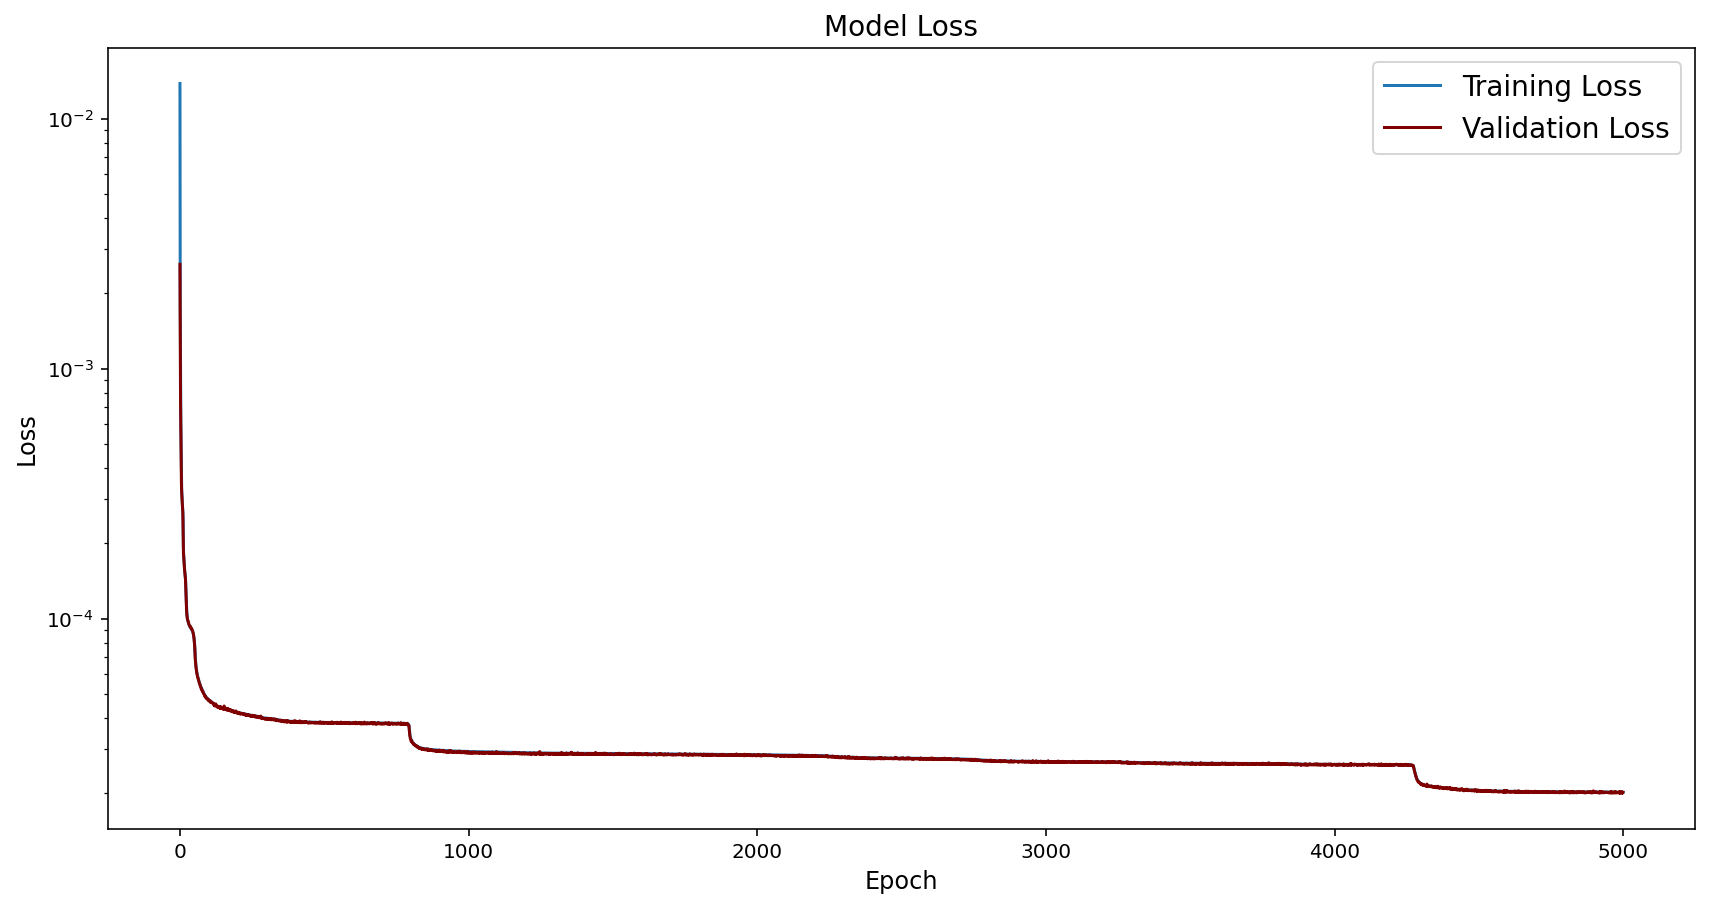

In [60]:
#plottig model accuracy
fig4 = plt.figure(figsize=(12,12))
"""ax4 = fig4.add_subplot(2,1,1)
ax4.plot(noisy_saved.history['accuracy'], label="Training Acc")
ax4.plot(noisy_saved.history['val_accuracy'], label="Validation Acc", color="maroon")
ax4.set_title("Model Acc", fontsize=14)
ax4.set_ylabel("Accuracy", fontsize=12)
ax4.set_xlabel("Epoch", fontsize=12)
ax4.legend(loc="best", frameon=True, fontsize=14)"""

#plotting model loss
ax5 = fig4.add_subplot(2,1,2)
ax5.semilogy(noisy_saved.history['loss'], label="Training Loss")
ax5.semilogy(noisy_saved.history['val_loss'], label="Validation Loss", color="maroon")
ax5.set_title("Model Loss", fontsize=14)
ax5.set_ylabel("Loss", fontsize=12)
ax5.set_xlabel("Epoch", fontsize=12)
ax5.legend(loc="best", frameon=True, fontsize=14)

fig4.tight_layout()
#fig4.savefig("Figures/model112-R2.png")

#### Predictions

In [61]:
temp_preds = model_mixed.predict(test_temp) #make the preds
print(temp_preds.shape)

(20736, 50)


#### Plotting

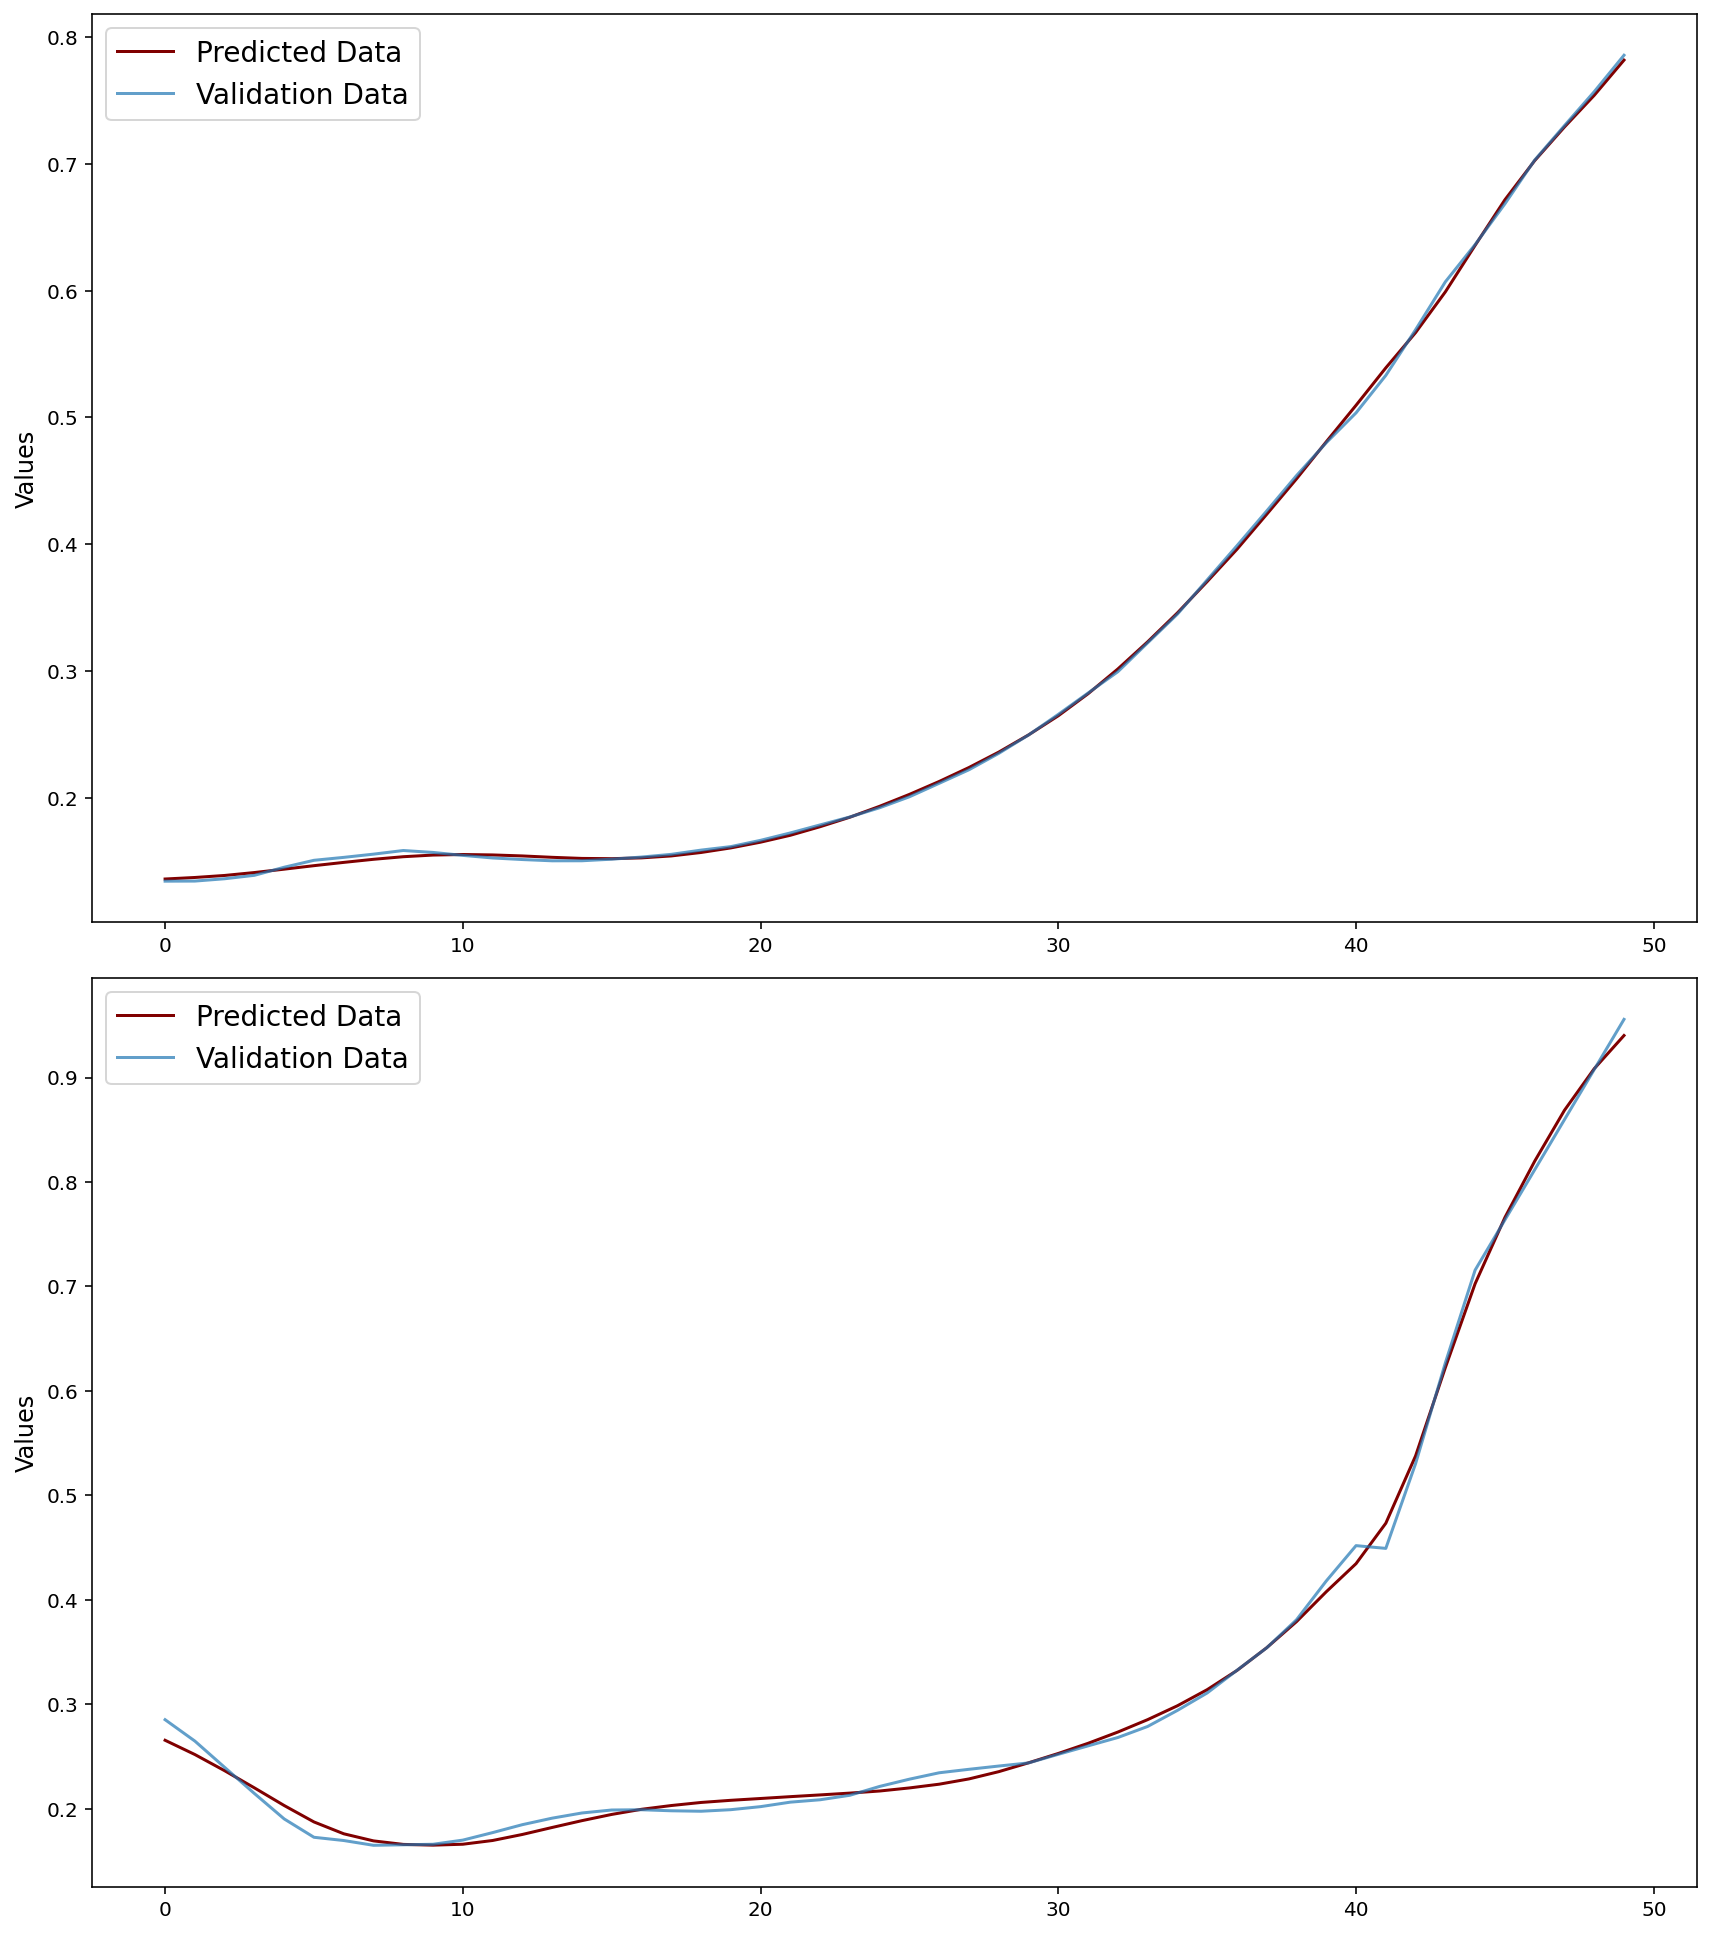

In [62]:
#temperature
fig1 = plt.figure(figsize=(12,20))

#example temp @ 0
ax7 = fig1.add_subplot(3,1,1)
ax7.plot(temp_preds[0], color="maroon", label="Predicted Data")
ax7.plot(test_temp[0], alpha=0.7, label="Validation Data")
#ax7.set_title("Validation Data vs Predicted Data (i=0)", fontsize=14)
ax7.set_ylabel("Values", fontsize=12)
ax7.legend(loc="best", frameon=True, fontsize=14)

#example vlos @ 0
ax9 = fig1.add_subplot(3,1,2)
ax9.plot(temp_preds[500], color="maroon", label="Predicted Data")
ax9.plot(test_temp[500], alpha=0.7, label="Validation Data")
#ax9.set_title("Validation Data vs Predicted Data (i=5000)", fontsize=14)
ax9.set_ylabel("Values", fontsize=12)
ax9.legend(loc="best", frameon=True, fontsize=14)

fig1.tight_layout()
#fig1.savefig("Nice/preds112-O2.png")

#### Fitting Model (vlos)

In [20]:
#choosing model to use
model_mixed2 = AE_both(14,ND)

#starts training
#ignore old naming conventions, just tryna see if this works for now
noisy_saved2 = model_mixed2.fit(train_vlos, train_vlos, validation_data=(test_vlos, test_vlos), epochs=5000, batch_size=32)

#evaluates training, just for sanity check really
scores = model_mixed2.evaluate(test_vlos, test_vlos, verbose=0)
print("Model Error: %.3f%%" % (100-scores[1]*100))

Epoch 1/5000
1944/1944 [==============================] - 1s 507us/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/5000
1944/1944 [==============================] - 1s 465us/step - loss: 0.0012 - mse: 0.0012 - val_loss: 9.3264e-04 - val_mse: 9.3264e-04
Epoch 3/5000
1944/1944 [==============================] - 1s 465us/step - loss: 8.2110e-04 - mse: 8.2110e-04 - val_loss: 7.7408e-04 - val_mse: 7.7408e-04
Epoch 4/5000
1944/1944 [==============================] - 1s 465us/step - loss: 7.3751e-04 - mse: 7.3751e-04 - val_loss: 7.2687e-04 - val_mse: 7.2687e-04
Epoch 5/5000
1944/1944 [==============================] - 1s 471us/step - loss: 6.8438e-04 - mse: 6.8438e-04 - val_loss: 6.4709e-04 - val_mse: 6.4709e-04
Epoch 6/5000
1944/1944 [==============================] - 1s 464us/step - loss: 5.3309e-04 - mse: 5.3309e-04 - val_loss: 4.3155e-04 - val_mse: 4.3155e-04
Epoch 7/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9193e-04 - mse: 3.

1944/1944 [==============================] - 1s 464us/step - loss: 7.9868e-05 - mse: 7.9868e-05 - val_loss: 7.9518e-05 - val_mse: 7.9518e-05
Epoch 55/5000
1944/1944 [==============================] - 1s 463us/step - loss: 7.9795e-05 - mse: 7.9795e-05 - val_loss: 7.9865e-05 - val_mse: 7.9865e-05
Epoch 56/5000
1944/1944 [==============================] - 1s 460us/step - loss: 7.9744e-05 - mse: 7.9744e-05 - val_loss: 7.9868e-05 - val_mse: 7.9868e-05
Epoch 57/5000
1944/1944 [==============================] - 1s 470us/step - loss: 7.9707e-05 - mse: 7.9707e-05 - val_loss: 7.9453e-05 - val_mse: 7.9453e-05
Epoch 58/5000
1944/1944 [==============================] - 1s 458us/step - loss: 7.9707e-05 - mse: 7.9707e-05 - val_loss: 8.0558e-05 - val_mse: 8.0558e-05
Epoch 59/5000
1944/1944 [==============================] - 1s 462us/step - loss: 7.9619e-05 - mse: 7.9619e-05 - val_loss: 8.1451e-05 - val_mse: 8.1451e-05
Epoch 60/5000
1944/1944 [==============================] - 1s 465us/step - loss: 7.9

Epoch 107/5000
1944/1944 [==============================] - 1s 463us/step - loss: 7.7973e-05 - mse: 7.7973e-05 - val_loss: 7.7358e-05 - val_mse: 7.7358e-05
Epoch 108/5000
1944/1944 [==============================] - 1s 463us/step - loss: 7.7910e-05 - mse: 7.7910e-05 - val_loss: 7.8428e-05 - val_mse: 7.8428e-05
Epoch 109/5000
1944/1944 [==============================] - 1s 464us/step - loss: 7.7786e-05 - mse: 7.7786e-05 - val_loss: 7.7275e-05 - val_mse: 7.7275e-05
Epoch 110/5000
1944/1944 [==============================] - 1s 463us/step - loss: 7.7638e-05 - mse: 7.7638e-05 - val_loss: 7.7510e-05 - val_mse: 7.7510e-05
Epoch 111/5000
1944/1944 [==============================] - 1s 464us/step - loss: 7.7613e-05 - mse: 7.7613e-05 - val_loss: 7.7265e-05 - val_mse: 7.7265e-05
Epoch 112/5000
1944/1944 [==============================] - 1s 465us/step - loss: 7.7421e-05 - mse: 7.7421e-05 - val_loss: 7.7641e-05 - val_mse: 7.7641e-05
Epoch 113/5000
1944/1944 [==============================] - 1s 4

1944/1944 [==============================] - 1s 465us/step - loss: 4.0337e-05 - mse: 4.0337e-05 - val_loss: 4.0744e-05 - val_mse: 4.0744e-05
Epoch 212/5000
1944/1944 [==============================] - 1s 464us/step - loss: 4.0349e-05 - mse: 4.0349e-05 - val_loss: 4.0139e-05 - val_mse: 4.0139e-05
Epoch 213/5000
1944/1944 [==============================] - 1s 459us/step - loss: 4.0348e-05 - mse: 4.0348e-05 - val_loss: 4.0211e-05 - val_mse: 4.0211e-05
Epoch 214/5000
1944/1944 [==============================] - 1s 457us/step - loss: 4.0340e-05 - mse: 4.0340e-05 - val_loss: 4.0912e-05 - val_mse: 4.0912e-05
Epoch 215/5000
1944/1944 [==============================] - 1s 455us/step - loss: 4.0317e-05 - mse: 4.0317e-05 - val_loss: 3.9673e-05 - val_mse: 3.9673e-05
Epoch 216/5000
1944/1944 [==============================] - 1s 456us/step - loss: 4.0328e-05 - mse: 4.0328e-05 - val_loss: 3.9838e-05 - val_mse: 3.9838e-05
Epoch 217/5000
1944/1944 [==============================] - 1s 456us/step - los

1944/1944 [==============================] - 1s 467us/step - loss: 3.9868e-05 - mse: 3.9868e-05 - val_loss: 3.9302e-05 - val_mse: 3.9302e-05
Epoch 316/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.9893e-05 - mse: 3.9893e-05 - val_loss: 3.9685e-05 - val_mse: 3.9685e-05
Epoch 317/5000
1944/1944 [==============================] - 1s 466us/step - loss: 3.9904e-05 - mse: 3.9904e-05 - val_loss: 3.9477e-05 - val_mse: 3.9477e-05
Epoch 318/5000
1944/1944 [==============================] - 1s 467us/step - loss: 3.9896e-05 - mse: 3.9896e-05 - val_loss: 3.9903e-05 - val_mse: 3.9903e-05
Epoch 319/5000
1944/1944 [==============================] - 1s 466us/step - loss: 3.9873e-05 - mse: 3.9873e-05 - val_loss: 3.9431e-05 - val_mse: 3.9431e-05
Epoch 320/5000
1944/1944 [==============================] - 1s 467us/step - loss: 3.9835e-05 - mse: 3.9835e-05 - val_loss: 3.9600e-05 - val_mse: 3.9600e-05
Epoch 321/5000
1944/1944 [==============================] - 1s 465us/step - los

1944/1944 [==============================] - ETA: 0s - loss: 3.9677e-05 - mse: 3.9677e-0 - 1s 466us/step - loss: 3.9675e-05 - mse: 3.9675e-05 - val_loss: 3.9242e-05 - val_mse: 3.9242e-05
Epoch 420/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9653e-05 - mse: 3.9653e-05 - val_loss: 4.0188e-05 - val_mse: 4.0188e-05
Epoch 421/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9651e-05 - mse: 3.9651e-05 - val_loss: 3.9377e-05 - val_mse: 3.9377e-05
Epoch 422/5000
1944/1944 [==============================] - 1s 466us/step - loss: 3.9641e-05 - mse: 3.9641e-05 - val_loss: 3.9318e-05 - val_mse: 3.9318e-05
Epoch 423/5000
1944/1944 [==============================] - 1s 469us/step - loss: 3.9631e-05 - mse: 3.9631e-05 - val_loss: 3.9423e-05 - val_mse: 3.9423e-05
Epoch 424/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.9640e-05 - mse: 3.9640e-05 - val_loss: 3.9205e-05 - val_mse: 3.9205e-05
Epoch 425/5000
1944/1944 [=======

1944/1944 [==============================] - 1s 462us/step - loss: 3.9560e-05 - mse: 3.9560e-05 - val_loss: 3.9147e-05 - val_mse: 3.9147e-05
Epoch 524/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.9583e-05 - mse: 3.9583e-05 - val_loss: 3.9110e-05 - val_mse: 3.9110e-05
Epoch 525/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.9559e-05 - mse: 3.9559e-05 - val_loss: 3.9480e-05 - val_mse: 3.9480e-05
Epoch 526/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.9524e-05 - mse: 3.9524e-05 - val_loss: 3.9512e-05 - val_mse: 3.9512e-05
Epoch 527/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.9558e-05 - mse: 3.9558e-05 - val_loss: 3.9444e-05 - val_mse: 3.9444e-05
Epoch 528/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9584e-05 - mse: 3.9584e-05 - val_loss: 3.9298e-05 - val_mse: 3.9298e-05
Epoch 529/5000
1944/1944 [==============================] - 1s 468us/step - los

1944/1944 [==============================] - 1s 465us/step - loss: 3.9523e-05 - mse: 3.9523e-05 - val_loss: 3.9380e-05 - val_mse: 3.9380e-05
Epoch 628/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.9529e-05 - mse: 3.9529e-05 - val_loss: 3.9607e-05 - val_mse: 3.9607e-05
Epoch 629/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9550e-05 - mse: 3.9550e-05 - val_loss: 3.9462e-05 - val_mse: 3.9462e-05
Epoch 630/5000
1944/1944 [==============================] - 1s 466us/step - loss: 3.9529e-05 - mse: 3.9529e-05 - val_loss: 3.9222e-05 - val_mse: 3.9222e-05
Epoch 631/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.9499e-05 - mse: 3.9499e-05 - val_loss: 3.9893e-05 - val_mse: 3.9893e-05
Epoch 632/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9549e-05 - mse: 3.9549e-05 - val_loss: 3.9261e-05 - val_mse: 3.9261e-05
Epoch 633/5000
1944/1944 [==============================] - 1s 464us/step - los

1944/1944 [==============================] - 1s 474us/step - loss: 3.9488e-05 - mse: 3.9488e-05 - val_loss: 4.0077e-05 - val_mse: 4.0077e-05
Epoch 732/5000
1944/1944 [==============================] - 1s 475us/step - loss: 3.9502e-05 - mse: 3.9502e-05 - val_loss: 3.9121e-05 - val_mse: 3.9121e-05
Epoch 733/5000
1944/1944 [==============================] - 1s 476us/step - loss: 3.9495e-05 - mse: 3.9495e-05 - val_loss: 3.9225e-05 - val_mse: 3.9225e-05
Epoch 734/5000
1944/1944 [==============================] - 1s 474us/step - loss: 3.9466e-05 - mse: 3.9466e-05 - val_loss: 3.9484e-05 - val_mse: 3.9484e-05
Epoch 735/5000
1944/1944 [==============================] - 1s 475us/step - loss: 3.9511e-05 - mse: 3.9511e-05 - val_loss: 3.8928e-05 - val_mse: 3.8928e-05
Epoch 736/5000
1944/1944 [==============================] - 1s 476us/step - loss: 3.9503e-05 - mse: 3.9503e-05 - val_loss: 3.9246e-05 - val_mse: 3.9246e-05
Epoch 737/5000
1944/1944 [==============================] - 1s 475us/step - los

1944/1944 [==============================] - 1s 463us/step - loss: 3.9218e-05 - mse: 3.9218e-05 - val_loss: 3.8638e-05 - val_mse: 3.8638e-05
Epoch 836/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.9253e-05 - mse: 3.9253e-05 - val_loss: 3.9822e-05 - val_mse: 3.9822e-05
Epoch 837/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.9261e-05 - mse: 3.9261e-05 - val_loss: 3.9187e-05 - val_mse: 3.9187e-05
Epoch 838/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9238e-05 - mse: 3.9238e-05 - val_loss: 3.9028e-05 - val_mse: 3.9028e-05
Epoch 839/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.9246e-05 - mse: 3.9246e-05 - val_loss: 3.8730e-05 - val_mse: 3.8730e-05
Epoch 840/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.9266e-05 - mse: 3.9266e-05 - val_loss: 3.9571e-05 - val_mse: 3.9571e-05
Epoch 841/5000
1944/1944 [==============================] - 1s 466us/step - los

1944/1944 [==============================] - 1s 462us/step - loss: 3.9132e-05 - mse: 3.9132e-05 - val_loss: 3.8666e-05 - val_mse: 3.8666e-05
Epoch 940/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.9168e-05 - mse: 3.9168e-05 - val_loss: 3.9000e-05 - val_mse: 3.9000e-05
Epoch 941/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.9171e-05 - mse: 3.9171e-05 - val_loss: 3.9062e-05 - val_mse: 3.9062e-05
Epoch 942/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.9148e-05 - mse: 3.9148e-05 - val_loss: 3.8652e-05 - val_mse: 3.8652e-05
Epoch 943/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.9145e-05 - mse: 3.9145e-05 - val_loss: 3.9394e-05 - val_mse: 3.9394e-05
Epoch 944/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.9114e-05 - mse: 3.9114e-05 - val_loss: 3.8856e-05 - val_mse: 3.8856e-05
Epoch 945/5000
1944/1944 [==============================] - 1s 465us/step - los

1944/1944 [==============================] - 1s 474us/step - loss: 3.5403e-05 - mse: 3.5403e-05 - val_loss: 3.5055e-05 - val_mse: 3.5055e-05
Epoch 1044/5000
1944/1944 [==============================] - 1s 461us/step - loss: 3.5369e-05 - mse: 3.5369e-05 - val_loss: 3.5150e-05 - val_mse: 3.5150e-05
Epoch 1045/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.5358e-05 - mse: 3.5358e-05 - val_loss: 3.5017e-05 - val_mse: 3.5017e-05
Epoch 1046/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.5334e-05 - mse: 3.5334e-05 - val_loss: 3.4874e-05 - val_mse: 3.4874e-05
Epoch 1047/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.5336e-05 - mse: 3.5336e-05 - val_loss: 3.5044e-05 - val_mse: 3.5044e-05
Epoch 1048/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.5288e-05 - mse: 3.5288e-05 - val_loss: 3.5054e-05 - val_mse: 3.5054e-05
Epoch 1049/5000
1944/1944 [==============================] - 1s 463us/step

1944/1944 [==============================] - 1s 463us/step - loss: 3.4982e-05 - mse: 3.4982e-05 - val_loss: 3.4527e-05 - val_mse: 3.4527e-05
Epoch 1148/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4981e-05 - mse: 3.4981e-05 - val_loss: 3.4619e-05 - val_mse: 3.4619e-05
Epoch 1149/5000
1944/1944 [==============================] - 1s 461us/step - loss: 3.4945e-05 - mse: 3.4945e-05 - val_loss: 3.4997e-05 - val_mse: 3.4997e-05
Epoch 1150/5000
1944/1944 [==============================] - 1s 461us/step - loss: 3.4972e-05 - mse: 3.4972e-05 - val_loss: 3.4512e-05 - val_mse: 3.4512e-05
Epoch 1151/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.4968e-05 - mse: 3.4968e-05 - val_loss: 3.4464e-05 - val_mse: 3.4464e-05
Epoch 1152/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.4961e-05 - mse: 3.4961e-05 - val_loss: 3.4634e-05 - val_mse: 3.4634e-05
Epoch 1153/5000
1944/1944 [==============================] - 1s 462us/step

1944/1944 [==============================] - 1s 463us/step - loss: 3.4903e-05 - mse: 3.4903e-05 - val_loss: 3.4861e-05 - val_mse: 3.4861e-05
Epoch 1252/5000
1944/1944 [==============================] - 1s 461us/step - loss: 3.4901e-05 - mse: 3.4901e-05 - val_loss: 3.4763e-05 - val_mse: 3.4763e-05
Epoch 1253/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.4912e-05 - mse: 3.4912e-05 - val_loss: 3.4788e-05 - val_mse: 3.4788e-05
Epoch 1254/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.4902e-05 - mse: 3.4902e-05 - val_loss: 3.4482e-05 - val_mse: 3.4482e-05
Epoch 1255/5000
1944/1944 [==============================] - 1s 466us/step - loss: 3.4919e-05 - mse: 3.4919e-05 - val_loss: 3.4903e-05 - val_mse: 3.4903e-05
Epoch 1256/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4884e-05 - mse: 3.4884e-05 - val_loss: 3.4844e-05 - val_mse: 3.4844e-05
Epoch 1257/5000
1944/1944 [==============================] - 1s 460us/step

1944/1944 [==============================] - 1s 462us/step - loss: 3.4871e-05 - mse: 3.4871e-05 - val_loss: 3.4444e-05 - val_mse: 3.4444e-05
Epoch 1356/5000
1944/1944 [==============================] - 1s 469us/step - loss: 3.4876e-05 - mse: 3.4876e-05 - val_loss: 3.4392e-05 - val_mse: 3.4392e-05
Epoch 1357/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.4860e-05 - mse: 3.4860e-05 - val_loss: 3.4453e-05 - val_mse: 3.4453e-05
Epoch 1358/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.4890e-05 - mse: 3.4890e-05 - val_loss: 3.4543e-05 - val_mse: 3.4543e-05
Epoch 1359/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4861e-05 - mse: 3.4861e-05 - val_loss: 3.4425e-05 - val_mse: 3.4425e-05
Epoch 1360/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.4885e-05 - mse: 3.4885e-05 - val_loss: 3.4440e-05 - val_mse: 3.4440e-05
Epoch 1361/5000
1944/1944 [==============================] - 1s 463us/step

1944/1944 [==============================] - 1s 464us/step - loss: 3.4767e-05 - mse: 3.4767e-05 - val_loss: 3.4276e-05 - val_mse: 3.4276e-05
Epoch 1460/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.4777e-05 - mse: 3.4777e-05 - val_loss: 3.4353e-05 - val_mse: 3.4353e-05
Epoch 1461/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4780e-05 - mse: 3.4780e-05 - val_loss: 3.4385e-05 - val_mse: 3.4385e-05
Epoch 1462/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.4774e-05 - mse: 3.4774e-05 - val_loss: 3.4381e-05 - val_mse: 3.4381e-05
Epoch 1463/5000
1944/1944 [==============================] - 1s 462us/step - loss: 3.4786e-05 - mse: 3.4786e-05 - val_loss: 3.4428e-05 - val_mse: 3.4428e-05
Epoch 1464/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4785e-05 - mse: 3.4785e-05 - val_loss: 3.4428e-05 - val_mse: 3.4428e-05
Epoch 1465/5000
1944/1944 [==============================] - 1s 462us/step

1944/1944 [==============================] - 1s 465us/step - loss: 3.4745e-05 - mse: 3.4745e-05 - val_loss: 3.4384e-05 - val_mse: 3.4384e-05
Epoch 1564/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.4754e-05 - mse: 3.4754e-05 - val_loss: 3.4713e-05 - val_mse: 3.4713e-05
Epoch 1565/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.4778e-05 - mse: 3.4778e-05 - val_loss: 3.4547e-05 - val_mse: 3.4547e-05
Epoch 1566/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.4755e-05 - mse: 3.4755e-05 - val_loss: 3.5117e-05 - val_mse: 3.5117e-05
Epoch 1567/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4741e-05 - mse: 3.4741e-05 - val_loss: 3.4565e-05 - val_mse: 3.4565e-05
Epoch 1568/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.4749e-05 - mse: 3.4749e-05 - val_loss: 3.4394e-05 - val_mse: 3.4394e-05
Epoch 1569/5000
1944/1944 [==============================] - 1s 462us/step

Epoch 1615/5000
1944/1944 [==============================] - 1s 456us/step - loss: 3.4756e-05 - mse: 3.4756e-05 - val_loss: 3.4397e-05 - val_mse: 3.4397e-05
Epoch 1616/5000
1944/1944 [==============================] - 1s 456us/step - loss: 3.4762e-05 - mse: 3.4762e-05 - val_loss: 3.4497e-05 - val_mse: 3.4497e-05
Epoch 1617/5000
1944/1944 [==============================] - 1s 453us/step - loss: 3.4740e-05 - mse: 3.4740e-05 - val_loss: 3.4264e-05 - val_mse: 3.4264e-05
Epoch 1618/5000
1944/1944 [==============================] - 1s 456us/step - loss: 3.4749e-05 - mse: 3.4749e-05 - val_loss: 3.4329e-05 - val_mse: 3.4329e-05
Epoch 1619/5000
1944/1944 [==============================] - 1s 456us/step - loss: 3.4754e-05 - mse: 3.4754e-05 - val_loss: 3.4312e-05 - val_mse: 3.4312e-05
Epoch 1620/5000
1944/1944 [==============================] - 1s 458us/step - loss: 3.4737e-05 - mse: 3.4737e-05 - val_loss: 3.4356e-05 - val_mse: 3.4356e-05
Epoch 1621/5000
1944/1944 [==============================]

1944/1944 [==============================] - 1s 467us/step - loss: 3.4737e-05 - mse: 3.4737e-05 - val_loss: 3.4418e-05 - val_mse: 3.4418e-05
Epoch 1720/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.4719e-05 - mse: 3.4719e-05 - val_loss: 3.4442e-05 - val_mse: 3.4442e-05
Epoch 1721/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.4731e-05 - mse: 3.4731e-05 - val_loss: 3.4492e-05 - val_mse: 3.4492e-05
Epoch 1722/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.4738e-05 - mse: 3.4738e-05 - val_loss: 3.4490e-05 - val_mse: 3.4490e-05
Epoch 1723/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4734e-05 - mse: 3.4734e-05 - val_loss: 3.4639e-05 - val_mse: 3.4639e-05
Epoch 1724/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.4739e-05 - mse: 3.4739e-05 - val_loss: 3.4726e-05 - val_mse: 3.4726e-05
Epoch 1725/5000
1944/1944 [==============================] - 1s 462us/step

1944/1944 [==============================] - 1s 465us/step - loss: 3.3789e-05 - mse: 3.3789e-05 - val_loss: 3.3389e-05 - val_mse: 3.3389e-05
Epoch 1824/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.3769e-05 - mse: 3.3769e-05 - val_loss: 3.3319e-05 - val_mse: 3.3319e-05
Epoch 1825/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.3778e-05 - mse: 3.3778e-05 - val_loss: 3.3331e-05 - val_mse: 3.3331e-05
Epoch 1826/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.3772e-05 - mse: 3.3772e-05 - val_loss: 3.3554e-05 - val_mse: 3.3554e-05
Epoch 1827/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.3765e-05 - mse: 3.3765e-05 - val_loss: 3.3204e-05 - val_mse: 3.3204e-05
Epoch 1828/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.3766e-05 - mse: 3.3766e-05 - val_loss: 3.3568e-05 - val_mse: 3.3568e-05
Epoch 1829/5000
1944/1944 [==============================] - 1s 465us/step

1944/1944 [==============================] - 1s 469us/step - loss: 3.3719e-05 - mse: 3.3719e-05 - val_loss: 3.3613e-05 - val_mse: 3.3613e-05
Epoch 1928/5000
1944/1944 [==============================] - 1s 470us/step - loss: 3.3712e-05 - mse: 3.3712e-05 - val_loss: 3.3436e-05 - val_mse: 3.3436e-05
Epoch 1929/5000
1944/1944 [==============================] - 1s 467us/step - loss: 3.3710e-05 - mse: 3.3710e-05 - val_loss: 3.3384e-05 - val_mse: 3.3384e-05
Epoch 1930/5000
1944/1944 [==============================] - 1s 467us/step - loss: 3.3716e-05 - mse: 3.3716e-05 - val_loss: 3.3226e-05 - val_mse: 3.3226e-05
Epoch 1931/5000
1944/1944 [==============================] - 1s 473us/step - loss: 3.3707e-05 - mse: 3.3707e-05 - val_loss: 3.3397e-05 - val_mse: 3.3397e-05
Epoch 1932/5000
1944/1944 [==============================] - 1s 468us/step - loss: 3.3702e-05 - mse: 3.3702e-05 - val_loss: 3.3417e-05 - val_mse: 3.3417e-05
Epoch 1933/5000
1944/1944 [==============================] - 1s 468us/step

1944/1944 [==============================] - 1s 472us/step - loss: 3.3697e-05 - mse: 3.3697e-05 - val_loss: 3.3469e-05 - val_mse: 3.3469e-05
Epoch 2032/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.3696e-05 - mse: 3.3696e-05 - val_loss: 3.3281e-05 - val_mse: 3.3281e-05
Epoch 2033/5000
1944/1944 [==============================] - 1s 461us/step - loss: 3.3689e-05 - mse: 3.3689e-05 - val_loss: 3.3212e-05 - val_mse: 3.3212e-05
Epoch 2034/5000
1944/1944 [==============================] - 1s 464us/step - loss: 3.3695e-05 - mse: 3.3695e-05 - val_loss: 3.3341e-05 - val_mse: 3.3341e-05
Epoch 2035/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.3695e-05 - mse: 3.3695e-05 - val_loss: 3.3373e-05 - val_mse: 3.3373e-05
Epoch 2036/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.3690e-05 - mse: 3.3690e-05 - val_loss: 3.3101e-05 - val_mse: 3.3101e-05
Epoch 2037/5000
1944/1944 [==============================] - 1s 466us/step

1944/1944 [==============================] - 1s 470us/step - loss: 3.3697e-05 - mse: 3.3697e-05 - val_loss: 3.3429e-05 - val_mse: 3.3429e-05
Epoch 2136/5000
1944/1944 [==============================] - 1s 463us/step - loss: 3.3671e-05 - mse: 3.3671e-05 - val_loss: 3.3196e-05 - val_mse: 3.3196e-05
Epoch 2137/5000
1944/1944 [==============================] - 1s 465us/step - loss: 3.3683e-05 - mse: 3.3683e-05 - val_loss: 3.3398e-05 - val_mse: 3.3398e-05
Epoch 2138/5000
1944/1944 [==============================] - 1s 459us/step - loss: 3.3686e-05 - mse: 3.3686e-05 - val_loss: 3.3253e-05 - val_mse: 3.3253e-05
Epoch 2139/5000
1944/1944 [==============================] - 1s 455us/step - loss: 3.3685e-05 - mse: 3.3685e-05 - val_loss: 3.3136e-05 - val_mse: 3.3136e-05
Epoch 2140/5000
1944/1944 [==============================] - 1s 456us/step - loss: 3.3674e-05 - mse: 3.3674e-05 - val_loss: 3.3240e-05 - val_mse: 3.3240e-05
Epoch 2141/5000
1944/1944 [==============================] - 1s 459us/step

1944/1944 [==============================] - 1s 466us/step - loss: 2.4895e-05 - mse: 2.4895e-05 - val_loss: 2.4737e-05 - val_mse: 2.4737e-05
Epoch 2240/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.4870e-05 - mse: 2.4870e-05 - val_loss: 2.4816e-05 - val_mse: 2.4816e-05
Epoch 2241/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.4877e-05 - mse: 2.4877e-05 - val_loss: 2.4733e-05 - val_mse: 2.4733e-05
Epoch 2242/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.4853e-05 - mse: 2.4853e-05 - val_loss: 2.4899e-05 - val_mse: 2.4899e-05
Epoch 2243/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.4846e-05 - mse: 2.4846e-05 - val_loss: 2.4660e-05 - val_mse: 2.4660e-05
Epoch 2244/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.4838e-05 - mse: 2.4838e-05 - val_loss: 2.4524e-05 - val_mse: 2.4524e-05
Epoch 2245/5000
1944/1944 [==============================] - 1s 467us/step

1944/1944 [==============================] - 1s 475us/step - loss: 2.4636e-05 - mse: 2.4636e-05 - val_loss: 2.4334e-05 - val_mse: 2.4334e-05
Epoch 2344/5000
1944/1944 [==============================] - 1s 484us/step - loss: 2.4637e-05 - mse: 2.4637e-05 - val_loss: 2.4460e-05 - val_mse: 2.4460e-05
Epoch 2345/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.4620e-05 - mse: 2.4620e-05 - val_loss: 2.4394e-05 - val_mse: 2.4394e-05
Epoch 2346/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.4635e-05 - mse: 2.4635e-05 - val_loss: 2.4441e-05 - val_mse: 2.4441e-05
Epoch 2347/5000
1944/1944 [==============================] - 1s 474us/step - loss: 2.4631e-05 - mse: 2.4631e-05 - val_loss: 2.4448e-05 - val_mse: 2.4448e-05
Epoch 2348/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.4622e-05 - mse: 2.4622e-05 - val_loss: 2.4326e-05 - val_mse: 2.4326e-05
Epoch 2349/5000
1944/1944 [==============================] - 1s 475us/step

1944/1944 [==============================] - 1s 466us/step - loss: 2.4431e-05 - mse: 2.4431e-05 - val_loss: 2.4255e-05 - val_mse: 2.4255e-05
Epoch 2448/5000
1944/1944 [==============================] - 1s 466us/step - loss: 2.4424e-05 - mse: 2.4424e-05 - val_loss: 2.4314e-05 - val_mse: 2.4314e-05
Epoch 2449/5000
1944/1944 [==============================] - 1s 470us/step - loss: 2.4411e-05 - mse: 2.4411e-05 - val_loss: 2.4099e-05 - val_mse: 2.4099e-05
Epoch 2450/5000
1944/1944 [==============================] - 1s 467us/step - loss: 2.4411e-05 - mse: 2.4411e-05 - val_loss: 2.4219e-05 - val_mse: 2.4219e-05
Epoch 2451/5000
1944/1944 [==============================] - 1s 468us/step - loss: 2.4394e-05 - mse: 2.4394e-05 - val_loss: 2.4116e-05 - val_mse: 2.4116e-05
Epoch 2452/5000
1944/1944 [==============================] - 1s 475us/step - loss: 2.4407e-05 - mse: 2.4407e-05 - val_loss: 2.4182e-05 - val_mse: 2.4182e-05
Epoch 2453/5000
1944/1944 [==============================] - 1s 461us/step

1944/1944 [==============================] - 1s 462us/step - loss: 2.4166e-05 - mse: 2.4166e-05 - val_loss: 2.3936e-05 - val_mse: 2.3936e-05
Epoch 2552/5000
1944/1944 [==============================] - 1s 462us/step - loss: 2.4177e-05 - mse: 2.4177e-05 - val_loss: 2.3858e-05 - val_mse: 2.3858e-05
Epoch 2553/5000
1944/1944 [==============================] - 1s 469us/step - loss: 2.4177e-05 - mse: 2.4177e-05 - val_loss: 2.4119e-05 - val_mse: 2.4119e-05
Epoch 2554/5000
1944/1944 [==============================] - 1s 461us/step - loss: 2.4173e-05 - mse: 2.4173e-05 - val_loss: 2.3995e-05 - val_mse: 2.3995e-05
Epoch 2555/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.4176e-05 - mse: 2.4176e-05 - val_loss: 2.4043e-05 - val_mse: 2.4043e-05
Epoch 2556/5000
1944/1944 [==============================] - 1s 461us/step - loss: 2.4172e-05 - mse: 2.4172e-05 - val_loss: 2.3973e-05 - val_mse: 2.3973e-05
Epoch 2557/5000
1944/1944 [==============================] - 1s 461us/step

1944/1944 [==============================] - 1s 463us/step - loss: 2.3934e-05 - mse: 2.3934e-05 - val_loss: 2.3716e-05 - val_mse: 2.3716e-05
Epoch 2656/5000
1944/1944 [==============================] - 1s 461us/step - loss: 2.3921e-05 - mse: 2.3921e-05 - val_loss: 2.3803e-05 - val_mse: 2.3803e-05
Epoch 2657/5000
1944/1944 [==============================] - 1s 459us/step - loss: 2.3927e-05 - mse: 2.3927e-05 - val_loss: 2.3682e-05 - val_mse: 2.3682e-05
Epoch 2658/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.3914e-05 - mse: 2.3914e-05 - val_loss: 2.3775e-05 - val_mse: 2.3775e-05
Epoch 2659/5000
1944/1944 [==============================] - 1s 460us/step - loss: 2.3919e-05 - mse: 2.3919e-05 - val_loss: 2.3713e-05 - val_mse: 2.3713e-05
Epoch 2660/5000
1944/1944 [==============================] - 1s 462us/step - loss: 2.3915e-05 - mse: 2.3915e-05 - val_loss: 2.3632e-05 - val_mse: 2.3632e-05
Epoch 2661/5000
1944/1944 [==============================] - 1s 459us/step

1944/1944 [==============================] - 1s 463us/step - loss: 2.3707e-05 - mse: 2.3707e-05 - val_loss: 2.3449e-05 - val_mse: 2.3449e-05
Epoch 2760/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.3729e-05 - mse: 2.3729e-05 - val_loss: 2.3487e-05 - val_mse: 2.3487e-05
Epoch 2761/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.3700e-05 - mse: 2.3700e-05 - val_loss: 2.3553e-05 - val_mse: 2.3553e-05
Epoch 2762/5000
1944/1944 [==============================] - 1s 463us/step - loss: 2.3709e-05 - mse: 2.3709e-05 - val_loss: 2.3438e-05 - val_mse: 2.3438e-05
Epoch 2763/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.3714e-05 - mse: 2.3714e-05 - val_loss: 2.3561e-05 - val_mse: 2.3561e-05
Epoch 2764/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.3703e-05 - mse: 2.3703e-05 - val_loss: 2.3553e-05 - val_mse: 2.3553e-05
Epoch 2765/5000
1944/1944 [==============================] - 1s 466us/step

1944/1944 [==============================] - 1s 461us/step - loss: 2.3417e-05 - mse: 2.3417e-05 - val_loss: 2.3217e-05 - val_mse: 2.3217e-05
Epoch 2864/5000
1944/1944 [==============================] - 1s 459us/step - loss: 2.3389e-05 - mse: 2.3389e-05 - val_loss: 2.3240e-05 - val_mse: 2.3240e-05
Epoch 2865/5000
1944/1944 [==============================] - 1s 459us/step - loss: 2.3383e-05 - mse: 2.3383e-05 - val_loss: 2.3213e-05 - val_mse: 2.3213e-05
Epoch 2866/5000
1944/1944 [==============================] - 1s 459us/step - loss: 2.3369e-05 - mse: 2.3369e-05 - val_loss: 2.3166e-05 - val_mse: 2.3166e-05
Epoch 2867/5000
1944/1944 [==============================] - 1s 464us/step - loss: 2.3338e-05 - mse: 2.3338e-05 - val_loss: 2.3161e-05 - val_mse: 2.3161e-05
Epoch 2868/5000
1944/1944 [==============================] - 1s 465us/step - loss: 2.3314e-05 - mse: 2.3314e-05 - val_loss: 2.3200e-05 - val_mse: 2.3200e-05
Epoch 2869/5000
1944/1944 [==============================] - 1s 468us/step

1944/1944 [==============================] - 1s 465us/step - loss: 1.7731e-05 - mse: 1.7731e-05 - val_loss: 1.7752e-05 - val_mse: 1.7752e-05
Epoch 2968/5000
1944/1944 [==============================] - 1s 466us/step - loss: 1.7755e-05 - mse: 1.7755e-05 - val_loss: 1.7578e-05 - val_mse: 1.7578e-05
Epoch 2969/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7739e-05 - mse: 1.7739e-05 - val_loss: 1.7746e-05 - val_mse: 1.7746e-05
Epoch 2970/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7752e-05 - mse: 1.7752e-05 - val_loss: 1.7694e-05 - val_mse: 1.7694e-05
Epoch 2971/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7733e-05 - mse: 1.7733e-05 - val_loss: 1.7631e-05 - val_mse: 1.7631e-05
Epoch 2972/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7736e-05 - mse: 1.7736e-05 - val_loss: 1.8072e-05 - val_mse: 1.8072e-05
Epoch 2973/5000
1944/1944 [==============================] - 1s 461us/step

1944/1944 [==============================] - 1s 463us/step - loss: 1.7671e-05 - mse: 1.7671e-05 - val_loss: 1.7667e-05 - val_mse: 1.7667e-05
Epoch 3072/5000
1944/1944 [==============================] - 1s 469us/step - loss: 1.7656e-05 - mse: 1.7656e-05 - val_loss: 1.7549e-05 - val_mse: 1.7549e-05
Epoch 3073/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7677e-05 - mse: 1.7677e-05 - val_loss: 1.7536e-05 - val_mse: 1.7536e-05
Epoch 3074/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7655e-05 - mse: 1.7655e-05 - val_loss: 1.7561e-05 - val_mse: 1.7561e-05
Epoch 3075/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7659e-05 - mse: 1.7659e-05 - val_loss: 1.7506e-05 - val_mse: 1.7506e-05
Epoch 3076/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7664e-05 - mse: 1.7664e-05 - val_loss: 1.7563e-05 - val_mse: 1.7563e-05
Epoch 3077/5000
1944/1944 [==============================] - 1s 462us/step

1944/1944 [==============================] - 1s 460us/step - loss: 1.7631e-05 - mse: 1.7631e-05 - val_loss: 1.7544e-05 - val_mse: 1.7544e-05
Epoch 3176/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7634e-05 - mse: 1.7634e-05 - val_loss: 1.7586e-05 - val_mse: 1.7586e-05
Epoch 3177/5000
1944/1944 [==============================] - 1s 469us/step - loss: 1.7620e-05 - mse: 1.7620e-05 - val_loss: 1.7548e-05 - val_mse: 1.7548e-05
Epoch 3178/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7626e-05 - mse: 1.7626e-05 - val_loss: 1.7519e-05 - val_mse: 1.7519e-05
Epoch 3179/5000
1944/1944 [==============================] - 1s 458us/step - loss: 1.7630e-05 - mse: 1.7630e-05 - val_loss: 1.7596e-05 - val_mse: 1.7596e-05
Epoch 3180/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7625e-05 - mse: 1.7625e-05 - val_loss: 1.7454e-05 - val_mse: 1.7454e-05
Epoch 3181/5000
1944/1944 [==============================] - 1s 461us/step

1944/1944 [==============================] - 1s 467us/step - loss: 1.7607e-05 - mse: 1.7607e-05 - val_loss: 1.7707e-05 - val_mse: 1.7707e-05
Epoch 3280/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7617e-05 - mse: 1.7617e-05 - val_loss: 1.7544e-05 - val_mse: 1.7544e-05
Epoch 3281/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7611e-05 - mse: 1.7611e-05 - val_loss: 1.7642e-05 - val_mse: 1.7642e-05
Epoch 3282/5000
1944/1944 [==============================] - 1s 465us/step - loss: 1.7623e-05 - mse: 1.7623e-05 - val_loss: 1.7441e-05 - val_mse: 1.7441e-05
Epoch 3283/5000
1944/1944 [==============================] - 1s 470us/step - loss: 1.7611e-05 - mse: 1.7611e-05 - val_loss: 1.7547e-05 - val_mse: 1.7547e-05
Epoch 3284/5000
1944/1944 [==============================] - 1s 478us/step - loss: 1.7617e-05 - mse: 1.7617e-05 - val_loss: 1.7525e-05 - val_mse: 1.7525e-05
Epoch 3285/5000
1944/1944 [==============================] - 1s 465us/step

1944/1944 [==============================] - 1s 461us/step - loss: 1.7599e-05 - mse: 1.7599e-05 - val_loss: 1.7416e-05 - val_mse: 1.7416e-05
Epoch 3384/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7614e-05 - mse: 1.7614e-05 - val_loss: 1.7424e-05 - val_mse: 1.7424e-05
Epoch 3385/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7602e-05 - mse: 1.7602e-05 - val_loss: 1.7504e-05 - val_mse: 1.7504e-05
Epoch 3386/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7610e-05 - mse: 1.7610e-05 - val_loss: 1.7546e-05 - val_mse: 1.7546e-05
Epoch 3387/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7592e-05 - mse: 1.7592e-05 - val_loss: 1.7455e-05 - val_mse: 1.7455e-05
Epoch 3388/5000
1944/1944 [==============================] - 1s 466us/step - loss: 1.7602e-05 - mse: 1.7602e-05 - val_loss: 1.7486e-05 - val_mse: 1.7486e-05
Epoch 3389/5000
1944/1944 [==============================] - 1s 466us/step

1944/1944 [==============================] - 1s 467us/step - loss: 1.7599e-05 - mse: 1.7599e-05 - val_loss: 1.7460e-05 - val_mse: 1.7460e-05
Epoch 3488/5000
1944/1944 [==============================] - 1s 466us/step - loss: 1.7591e-05 - mse: 1.7591e-05 - val_loss: 1.7443e-05 - val_mse: 1.7443e-05
Epoch 3489/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7604e-05 - mse: 1.7604e-05 - val_loss: 1.7472e-05 - val_mse: 1.7472e-05
Epoch 3490/5000
1944/1944 [==============================] - 1s 467us/step - loss: 1.7595e-05 - mse: 1.7595e-05 - val_loss: 1.7526e-05 - val_mse: 1.7526e-05
Epoch 3491/5000
1944/1944 [==============================] - 1s 474us/step - loss: 1.7599e-05 - mse: 1.7599e-05 - val_loss: 1.7460e-05 - val_mse: 1.7460e-05
Epoch 3492/5000
1944/1944 [==============================] - 1s 465us/step - loss: 1.7599e-05 - mse: 1.7599e-05 - val_loss: 1.7541e-05 - val_mse: 1.7541e-05
Epoch 3493/5000
1944/1944 [==============================] - 1s 461us/step

1944/1944 [==============================] - 1s 465us/step - loss: 1.7548e-05 - mse: 1.7548e-05 - val_loss: 1.7419e-05 - val_mse: 1.7419e-05
Epoch 3592/5000
1944/1944 [==============================] - 1s 473us/step - loss: 1.7564e-05 - mse: 1.7564e-05 - val_loss: 1.7494e-05 - val_mse: 1.7494e-05
Epoch 3593/5000
1944/1944 [==============================] - 1s 465us/step - loss: 1.7546e-05 - mse: 1.7546e-05 - val_loss: 1.7378e-05 - val_mse: 1.7378e-05
Epoch 3594/5000
1944/1944 [==============================] - 1s 465us/step - loss: 1.7545e-05 - mse: 1.7545e-05 - val_loss: 1.7444e-05 - val_mse: 1.7444e-05
Epoch 3595/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7545e-05 - mse: 1.7545e-05 - val_loss: 1.7429e-05 - val_mse: 1.7429e-05
Epoch 3596/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7538e-05 - mse: 1.7538e-05 - val_loss: 1.7437e-05 - val_mse: 1.7437e-05
Epoch 3597/5000
1944/1944 [==============================] - 1s 460us/step

1944/1944 [==============================] - 1s 463us/step - loss: 1.7498e-05 - mse: 1.7498e-05 - val_loss: 1.7347e-05 - val_mse: 1.7347e-05
Epoch 3696/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7490e-05 - mse: 1.7490e-05 - val_loss: 1.7397e-05 - val_mse: 1.7397e-05
Epoch 3697/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7497e-05 - mse: 1.7497e-05 - val_loss: 1.7411e-05 - val_mse: 1.7411e-05
Epoch 3698/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7492e-05 - mse: 1.7492e-05 - val_loss: 1.7433e-05 - val_mse: 1.7433e-05
Epoch 3699/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7491e-05 - mse: 1.7491e-05 - val_loss: 1.7304e-05 - val_mse: 1.7304e-05
Epoch 3700/5000
1944/1944 [==============================] - 1s 467us/step - loss: 1.7497e-05 - mse: 1.7497e-05 - val_loss: 1.7399e-05 - val_mse: 1.7399e-05
Epoch 3701/5000
1944/1944 [==============================] - 1s 464us/step

1944/1944 [==============================] - 1s 465us/step - loss: 1.7452e-05 - mse: 1.7452e-05 - val_loss: 1.7335e-05 - val_mse: 1.7335e-05
Epoch 3800/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7467e-05 - mse: 1.7467e-05 - val_loss: 1.7291e-05 - val_mse: 1.7291e-05
Epoch 3801/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7471e-05 - mse: 1.7471e-05 - val_loss: 1.7297e-05 - val_mse: 1.7297e-05
Epoch 3802/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7482e-05 - mse: 1.7482e-05 - val_loss: 1.7363e-05 - val_mse: 1.7363e-05
Epoch 3803/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7457e-05 - mse: 1.7457e-05 - val_loss: 1.7339e-05 - val_mse: 1.7339e-05
Epoch 3804/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7452e-05 - mse: 1.7452e-05 - val_loss: 1.7448e-05 - val_mse: 1.7448e-05
Epoch 3805/5000
1944/1944 [==============================] - 1s 467us/step

1944/1944 [==============================] - 1s 462us/step - loss: 1.7436e-05 - mse: 1.7436e-05 - val_loss: 1.7526e-05 - val_mse: 1.7526e-05
Epoch 3904/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7437e-05 - mse: 1.7437e-05 - val_loss: 1.7422e-05 - val_mse: 1.7422e-05
Epoch 3905/5000
1944/1944 [==============================] - 1s 467us/step - loss: 1.7437e-05 - mse: 1.7437e-05 - val_loss: 1.7372e-05 - val_mse: 1.7372e-05
Epoch 3906/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7434e-05 - mse: 1.7434e-05 - val_loss: 1.7373e-05 - val_mse: 1.7373e-05
Epoch 3907/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7428e-05 - mse: 1.7428e-05 - val_loss: 1.7456e-05 - val_mse: 1.7456e-05
Epoch 3908/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7426e-05 - mse: 1.7426e-05 - val_loss: 1.7318e-05 - val_mse: 1.7318e-05
Epoch 3909/5000
1944/1944 [==============================] - 1s 465us/step

1944/1944 [==============================] - 1s 462us/step - loss: 1.7400e-05 - mse: 1.7400e-05 - val_loss: 1.7379e-05 - val_mse: 1.7379e-05
Epoch 4008/5000
1944/1944 [==============================] - 1s 469us/step - loss: 1.7411e-05 - mse: 1.7411e-05 - val_loss: 1.7420e-05 - val_mse: 1.7420e-05
Epoch 4009/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7396e-05 - mse: 1.7396e-05 - val_loss: 1.7428e-05 - val_mse: 1.7428e-05
Epoch 4010/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7417e-05 - mse: 1.7417e-05 - val_loss: 1.7312e-05 - val_mse: 1.7312e-05
Epoch 4011/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7402e-05 - mse: 1.7402e-05 - val_loss: 1.7378e-05 - val_mse: 1.7378e-05
Epoch 4012/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7408e-05 - mse: 1.7408e-05 - val_loss: 1.7397e-05 - val_mse: 1.7397e-05
Epoch 4013/5000
1944/1944 [==============================] - 1s 463us/step

1944/1944 [==============================] - 1s 464us/step - loss: 1.7390e-05 - mse: 1.7390e-05 - val_loss: 1.7449e-05 - val_mse: 1.7449e-05
Epoch 4112/5000
1944/1944 [==============================] - 1s 471us/step - loss: 1.7407e-05 - mse: 1.7407e-05 - val_loss: 1.7262e-05 - val_mse: 1.7262e-05
Epoch 4113/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7405e-05 - mse: 1.7405e-05 - val_loss: 1.7376e-05 - val_mse: 1.7376e-05
Epoch 4114/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7395e-05 - mse: 1.7395e-05 - val_loss: 1.7464e-05 - val_mse: 1.7464e-05
Epoch 4115/5000
1944/1944 [==============================] - 1s 465us/step - loss: 1.7397e-05 - mse: 1.7397e-05 - val_loss: 1.7298e-05 - val_mse: 1.7298e-05
Epoch 4116/5000
1944/1944 [==============================] - 1s 466us/step - loss: 1.7394e-05 - mse: 1.7394e-05 - val_loss: 1.7345e-05 - val_mse: 1.7345e-05
Epoch 4117/5000
1944/1944 [==============================] - 1s 464us/step

1944/1944 [==============================] - 1s 462us/step - loss: 1.7385e-05 - mse: 1.7385e-05 - val_loss: 1.7325e-05 - val_mse: 1.7325e-05
Epoch 4216/5000
1944/1944 [==============================] - 1s 472us/step - loss: 1.7408e-05 - mse: 1.7408e-05 - val_loss: 1.7477e-05 - val_mse: 1.7477e-05
Epoch 4217/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7393e-05 - mse: 1.7393e-05 - val_loss: 1.7304e-05 - val_mse: 1.7304e-05
Epoch 4218/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7391e-05 - mse: 1.7391e-05 - val_loss: 1.7289e-05 - val_mse: 1.7289e-05
Epoch 4219/5000
1944/1944 [==============================] - 1s 468us/step - loss: 1.7393e-05 - mse: 1.7393e-05 - val_loss: 1.7369e-05 - val_mse: 1.7369e-05
Epoch 4220/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7391e-05 - mse: 1.7391e-05 - val_loss: 1.7314e-05 - val_mse: 1.7314e-05
Epoch 4221/5000
1944/1944 [==============================] - 1s 460us/step

1944/1944 [==============================] - 1s 463us/step - loss: 1.7373e-05 - mse: 1.7373e-05 - val_loss: 1.7291e-05 - val_mse: 1.7291e-05
Epoch 4320/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7384e-05 - mse: 1.7384e-05 - val_loss: 1.7416e-05 - val_mse: 1.7416e-05
Epoch 4321/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7380e-05 - mse: 1.7380e-05 - val_loss: 1.7260e-05 - val_mse: 1.7260e-05
Epoch 4322/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7387e-05 - mse: 1.7387e-05 - val_loss: 1.7269e-05 - val_mse: 1.7269e-05
Epoch 4323/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7380e-05 - mse: 1.7380e-05 - val_loss: 1.7324e-05 - val_mse: 1.7324e-05
Epoch 4324/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7375e-05 - mse: 1.7375e-05 - val_loss: 1.7342e-05 - val_mse: 1.7342e-05
Epoch 4325/5000
1944/1944 [==============================] - 1s 460us/step

1944/1944 [==============================] - 1s 458us/step - loss: 1.7377e-05 - mse: 1.7377e-05 - val_loss: 1.7551e-05 - val_mse: 1.7551e-05
Epoch 4424/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7374e-05 - mse: 1.7374e-05 - val_loss: 1.7335e-05 - val_mse: 1.7335e-05
Epoch 4425/5000
1944/1944 [==============================] - 1s 460us/step - loss: 1.7373e-05 - mse: 1.7373e-05 - val_loss: 1.7277e-05 - val_mse: 1.7277e-05
Epoch 4426/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7370e-05 - mse: 1.7370e-05 - val_loss: 1.7376e-05 - val_mse: 1.7376e-05
Epoch 4427/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7376e-05 - mse: 1.7376e-05 - val_loss: 1.7410e-05 - val_mse: 1.7410e-05
Epoch 4428/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7387e-05 - mse: 1.7387e-05 - val_loss: 1.7336e-05 - val_mse: 1.7336e-05
Epoch 4429/5000
1944/1944 [==============================] - 1s 460us/step

1944/1944 [==============================] - 1s 471us/step - loss: 1.7367e-05 - mse: 1.7367e-05 - val_loss: 1.7495e-05 - val_mse: 1.7495e-05
Epoch 4528/5000
1944/1944 [==============================] - 1s 472us/step - loss: 1.7356e-05 - mse: 1.7356e-05 - val_loss: 1.7466e-05 - val_mse: 1.7466e-05
Epoch 4529/5000
1944/1944 [==============================] - 1s 459us/step - loss: 1.7357e-05 - mse: 1.7357e-05 - val_loss: 1.7341e-05 - val_mse: 1.7341e-05
Epoch 4530/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7366e-05 - mse: 1.7366e-05 - val_loss: 1.7404e-05 - val_mse: 1.7404e-05
Epoch 4531/5000
1944/1944 [==============================] - 1s 470us/step - loss: 1.7352e-05 - mse: 1.7352e-05 - val_loss: 1.7314e-05 - val_mse: 1.7314e-05
Epoch 4532/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7360e-05 - mse: 1.7360e-05 - val_loss: 1.7403e-05 - val_mse: 1.7403e-05
Epoch 4533/5000
1944/1944 [==============================] - 1s 463us/step

1944/1944 [==============================] - 1s 464us/step - loss: 1.7350e-05 - mse: 1.7350e-05 - val_loss: 1.7347e-05 - val_mse: 1.7347e-05
Epoch 4632/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7352e-05 - mse: 1.7352e-05 - val_loss: 1.7342e-05 - val_mse: 1.7342e-05
Epoch 4633/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7339e-05 - mse: 1.7339e-05 - val_loss: 1.7337e-05 - val_mse: 1.7337e-05
Epoch 4634/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7346e-05 - mse: 1.7346e-05 - val_loss: 1.7551e-05 - val_mse: 1.7551e-05
Epoch 4635/5000
1944/1944 [==============================] - 1s 466us/step - loss: 1.7345e-05 - mse: 1.7345e-05 - val_loss: 1.7265e-05 - val_mse: 1.7265e-05
Epoch 4636/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7341e-05 - mse: 1.7341e-05 - val_loss: 1.7307e-05 - val_mse: 1.7307e-05
Epoch 4637/5000
1944/1944 [==============================] - 1s 465us/step

1944/1944 [==============================] - 1s 461us/step - loss: 1.7325e-05 - mse: 1.7325e-05 - val_loss: 1.7342e-05 - val_mse: 1.7342e-05
Epoch 4736/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7332e-05 - mse: 1.7332e-05 - val_loss: 1.7311e-05 - val_mse: 1.7311e-05
Epoch 4737/5000
1944/1944 [==============================] - 1s 461us/step - loss: 1.7342e-05 - mse: 1.7342e-05 - val_loss: 1.7405e-05 - val_mse: 1.7405e-05
Epoch 4738/5000
1944/1944 [==============================] - 1s 472us/step - loss: 1.7338e-05 - mse: 1.7338e-05 - val_loss: 1.7303e-05 - val_mse: 1.7303e-05
Epoch 4739/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7326e-05 - mse: 1.7326e-05 - val_loss: 1.7305e-05 - val_mse: 1.7305e-05
Epoch 4740/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7334e-05 - mse: 1.7334e-05 - val_loss: 1.7390e-05 - val_mse: 1.7390e-05
Epoch 4741/5000
1944/1944 [==============================] - 1s 463us/step

1944/1944 [==============================] - 1s 466us/step - loss: 1.7311e-05 - mse: 1.7311e-05 - val_loss: 1.7207e-05 - val_mse: 1.7207e-05
Epoch 4840/5000
1944/1944 [==============================] - 1s 467us/step - loss: 1.7312e-05 - mse: 1.7312e-05 - val_loss: 1.7205e-05 - val_mse: 1.7205e-05
Epoch 4841/5000
1944/1944 [==============================] - 1s 464us/step - loss: 1.7313e-05 - mse: 1.7313e-05 - val_loss: 1.7255e-05 - val_mse: 1.7255e-05
Epoch 4842/5000
1944/1944 [==============================] - 1s 476us/step - loss: 1.7319e-05 - mse: 1.7319e-05 - val_loss: 1.7274e-05 - val_mse: 1.7274e-05
Epoch 4843/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7321e-05 - mse: 1.7321e-05 - val_loss: 1.7208e-05 - val_mse: 1.7208e-05
Epoch 4844/5000
1944/1944 [==============================] - 1s 462us/step - loss: 1.7315e-05 - mse: 1.7315e-05 - val_loss: 1.7326e-05 - val_mse: 1.7326e-05
Epoch 4845/5000
1944/1944 [==============================] - 1s 472us/step

1944/1944 [==============================] - 1s 457us/step - loss: 1.7294e-05 - mse: 1.7294e-05 - val_loss: 1.7253e-05 - val_mse: 1.7253e-05
Epoch 4944/5000
1944/1944 [==============================] - 1s 463us/step - loss: 1.7297e-05 - mse: 1.7297e-05 - val_loss: 1.7201e-05 - val_mse: 1.7201e-05
Epoch 4945/5000
1944/1944 [==============================] - 1s 457us/step - loss: 1.7291e-05 - mse: 1.7291e-05 - val_loss: 1.7280e-05 - val_mse: 1.7280e-05
Epoch 4946/5000
1944/1944 [==============================] - 1s 456us/step - loss: 1.7306e-05 - mse: 1.7306e-05 - val_loss: 1.7445e-05 - val_mse: 1.7445e-05
Epoch 4947/5000
1944/1944 [==============================] - 1s 458us/step - loss: 1.7290e-05 - mse: 1.7290e-05 - val_loss: 1.7253e-05 - val_mse: 1.7253e-05
Epoch 4948/5000
1944/1944 [==============================] - 1s 458us/step - loss: 1.7301e-05 - mse: 1.7301e-05 - val_loss: 1.7378e-05 - val_mse: 1.7378e-05
Epoch 4949/5000
1944/1944 [==============================] - 1s 459us/step

#### Saving H5

In [21]:
model_mixed2.save("vlos-noconv-bn14-1.h5")

#### Plotting Model Performance

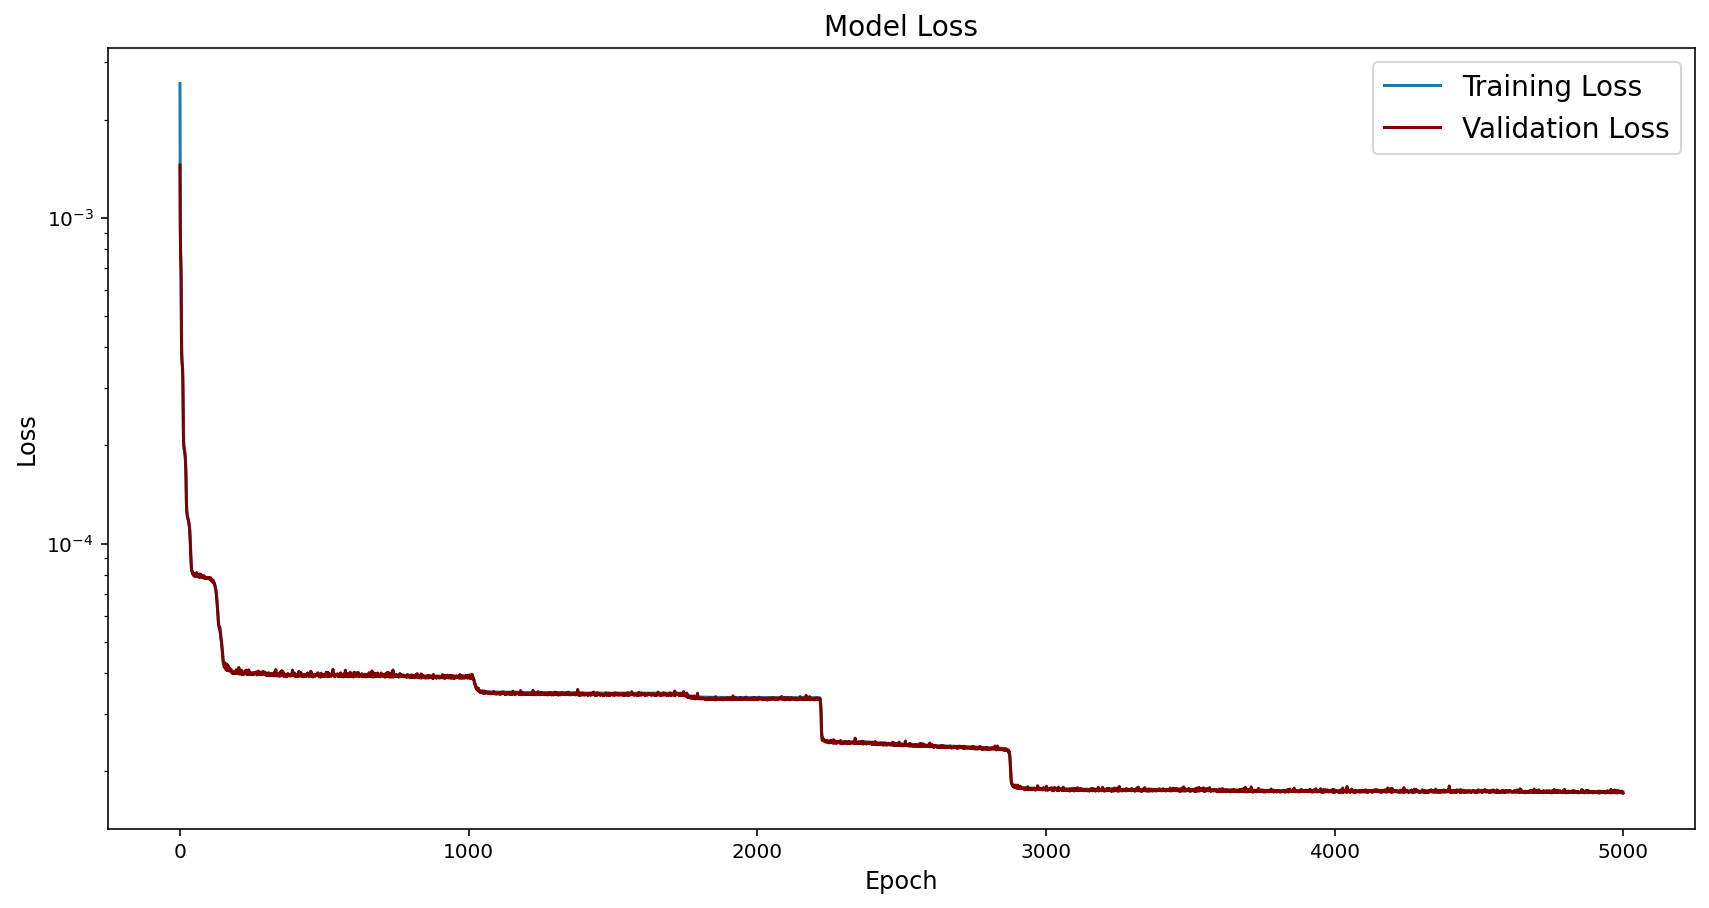

In [22]:
#plottig model accuracy
fig5 = plt.figure(figsize=(12,12))
"""ax4 = fig5.add_subplot(2,1,1)
ax4.plot(noisy_saved2.history['accuracy'], label="Training Acc")
ax4.plot(noisy_saved2.history['val_accuracy'], label="Validation Acc", color="maroon")
ax4.set_title("Model Acc", fontsize=14)
ax4.set_ylabel("Accuracy", fontsize=12)
ax4.set_xlabel("Epoch", fontsize=12)
ax4.legend(loc="best", frameon=True, fontsize=14)"""

#plotting model loss
ax5 = fig5.add_subplot(2,1,2)
ax5.semilogy(noisy_saved2.history['loss'], label="Training Loss")
ax5.semilogy(noisy_saved2.history['val_loss'], label="Validation Loss", color="maroon")
ax5.set_title("Model Loss", fontsize=14)
ax5.set_ylabel("Loss", fontsize=12)
ax5.set_xlabel("Epoch", fontsize=12)
ax5.legend(loc="best", frameon=True, fontsize=14)
#ax5.set_xlim([10,500])

fig5.tight_layout()
#fig4.savefig("Figures/model112-R2.png")

#### Predictions

In [23]:
vlos_preds = model_mixed2.predict(test_vlos) #make the preds
print(vlos_preds.shape)

(20736, 50)


#### Plotting Comparison

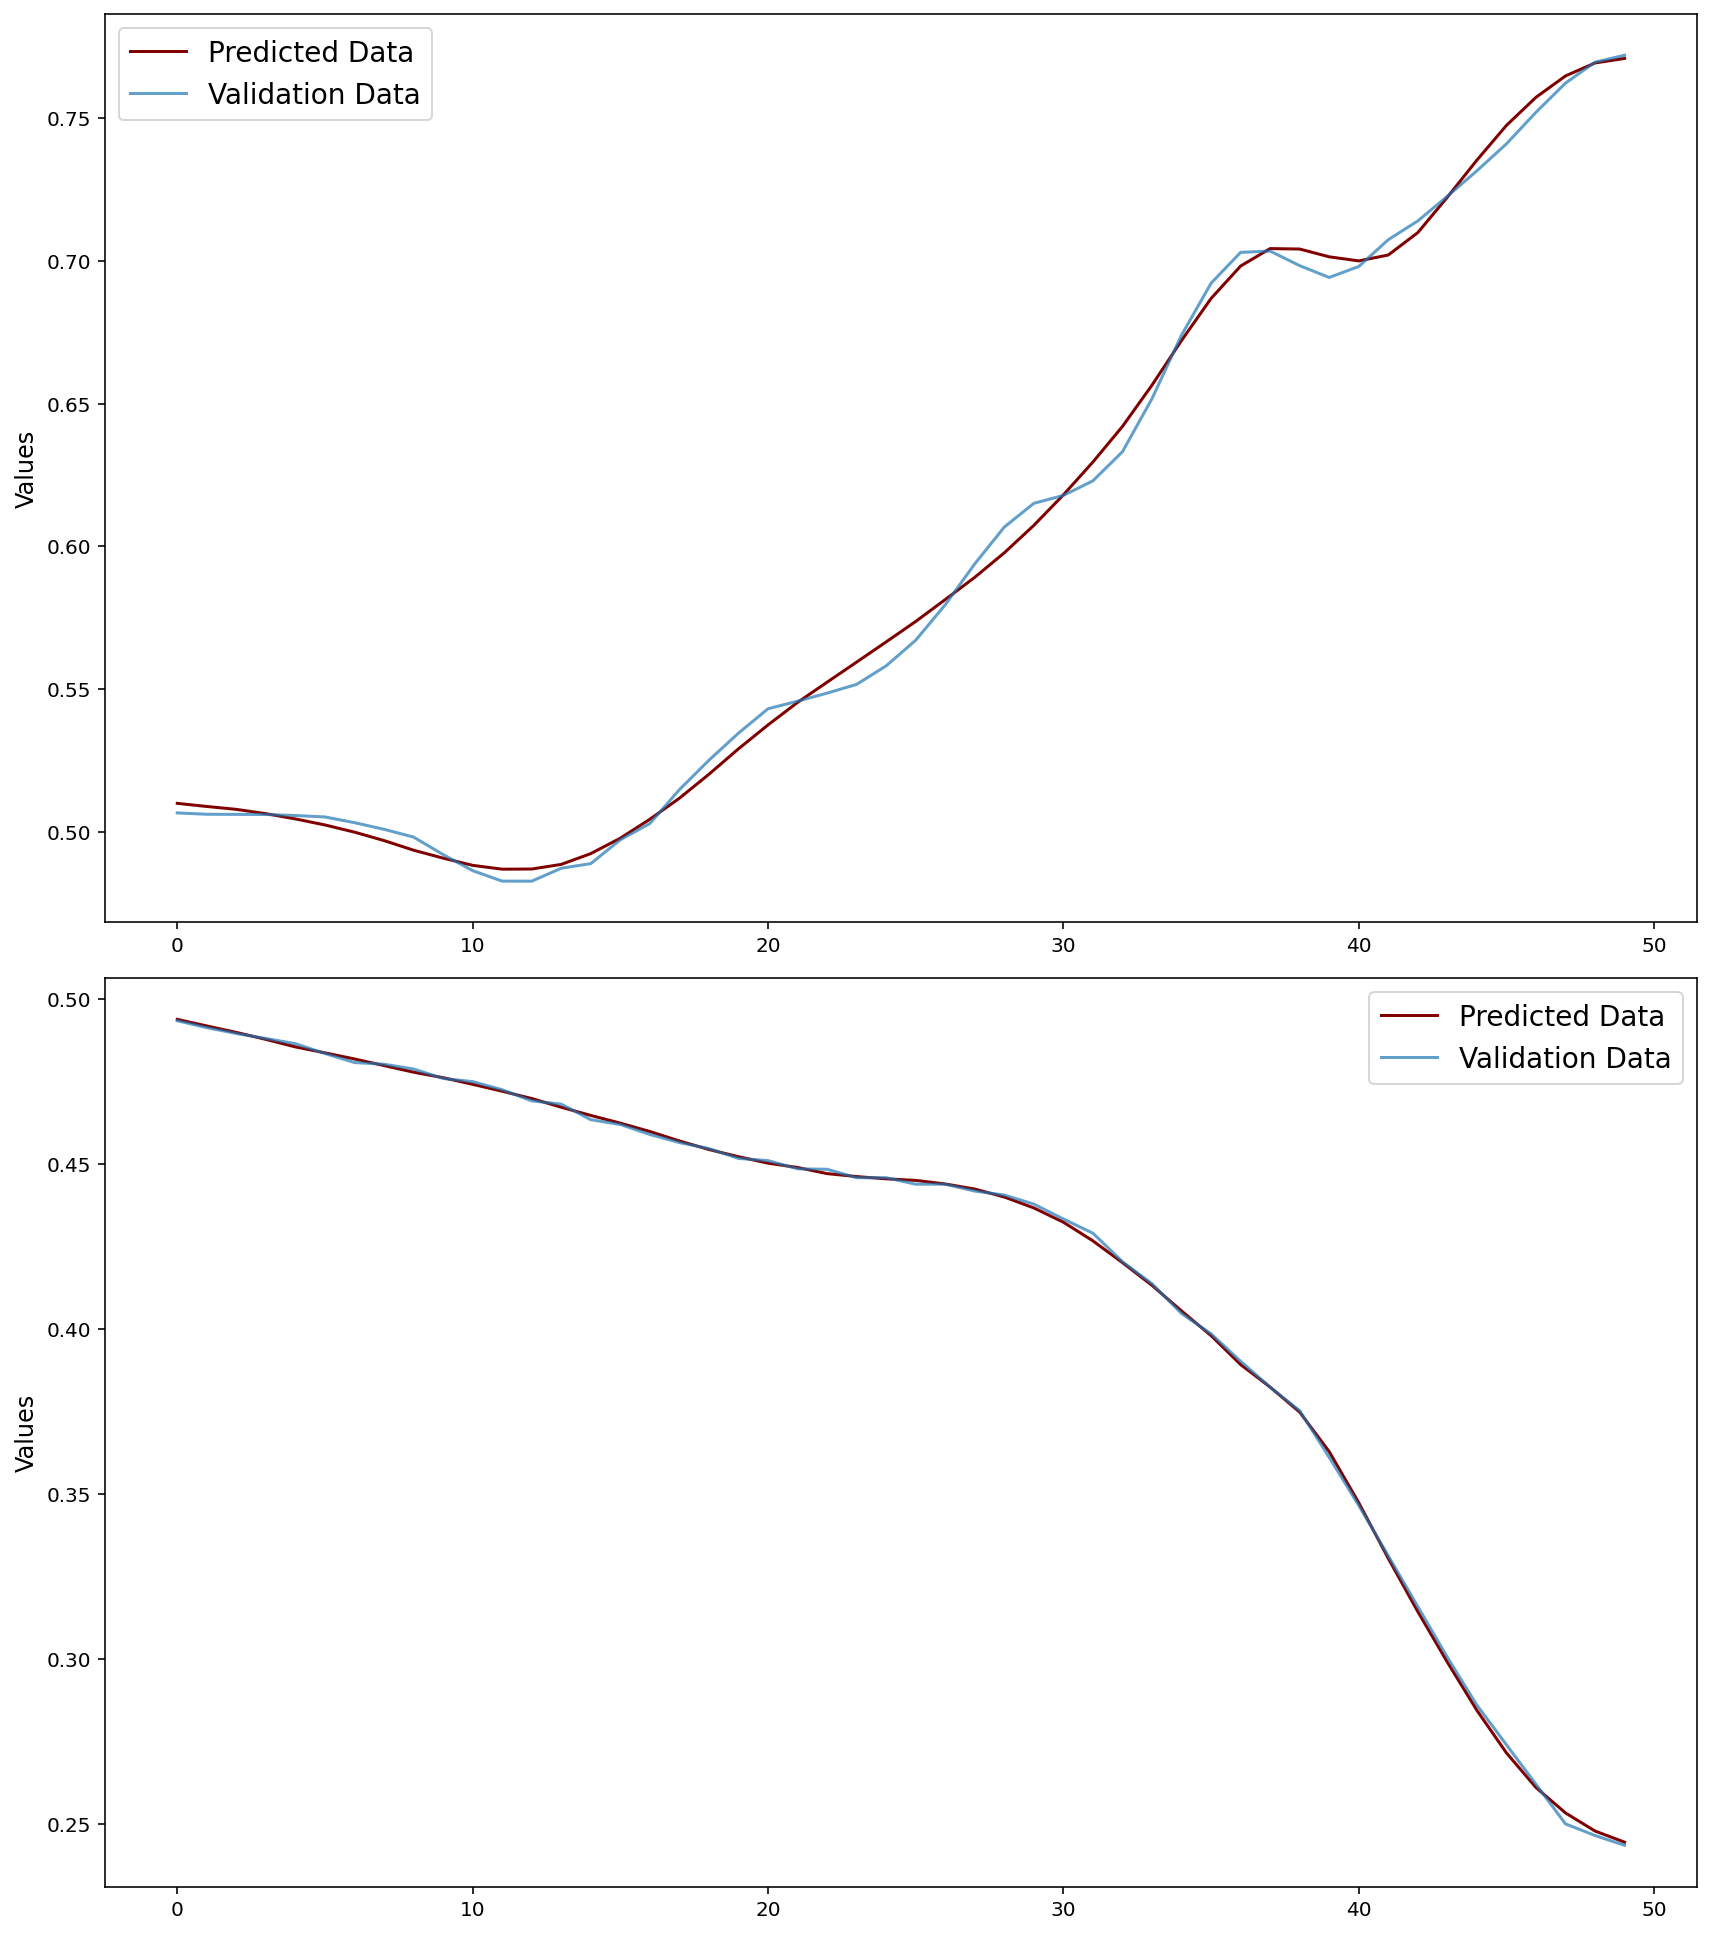

In [24]:
#temperature
fig2 = plt.figure(figsize=(12,20))

#example temp @ 0
ax7 = fig2.add_subplot(3,1,1)
ax7.plot(vlos_preds[54,:], color="maroon", label="Predicted Data")
ax7.plot(test_vlos[54,:], alpha=0.7, label="Validation Data")
#ax7.set_title("Validation Data vs Predicted Data (i=0)", fontsize=14)
ax7.set_ylabel("Values", fontsize=12)
ax7.legend(loc="best", frameon=True, fontsize=14)

#example vlos @ 0
ax9 = fig2.add_subplot(3,1,2)
ax9.plot(vlos_preds[5,:], color="maroon", label="Predicted Data")
ax9.plot(test_vlos[5,:], alpha=0.7, label="Validation Data")
#ax9.set_title("Validation Data vs Predicted Data (i=5000)", fontsize=14)
ax9.set_ylabel("Values", fontsize=12)
ax9.legend(loc="best", frameon=True, fontsize=14)

fig2.tight_layout()
#fig1.savefig("Nice/preds112-O2.png")

## Packaging up Results

#### Denormalizing

In [64]:
# We need to denormalize and save

def de_normalize_all(arr, max_val, min_val):
    arr2 = np.empty(arr.shape)
    for i in range(0,arr.shape[0]):
        for j in range(0,arr.shape[1]):
            arr2[i,j] = arr[i,j]*(max_val-min_val) + min_val
    return arr2

In [65]:
preds_1 = model_mixed.predict(norm_temp) #make the preds

denorm_preds_1 = de_normalize_all(preds_1,max_cut_temp,min_cut_temp)
denorm_og_1 = de_normalize_all(norm_temp,max_cut_temp,min_cut_temp)

In [66]:
preds_2 = model_mixed2.predict(norm_vlos) #make the preds

denorm_preds_2 = de_normalize_all(preds_2,max_cut_vlos,min_cut_vlos)
denorm_ogb_2 = de_normalize_all(norm_vlos,max_cut_vlos,min_cut_vlos)

#### Parameter Maps

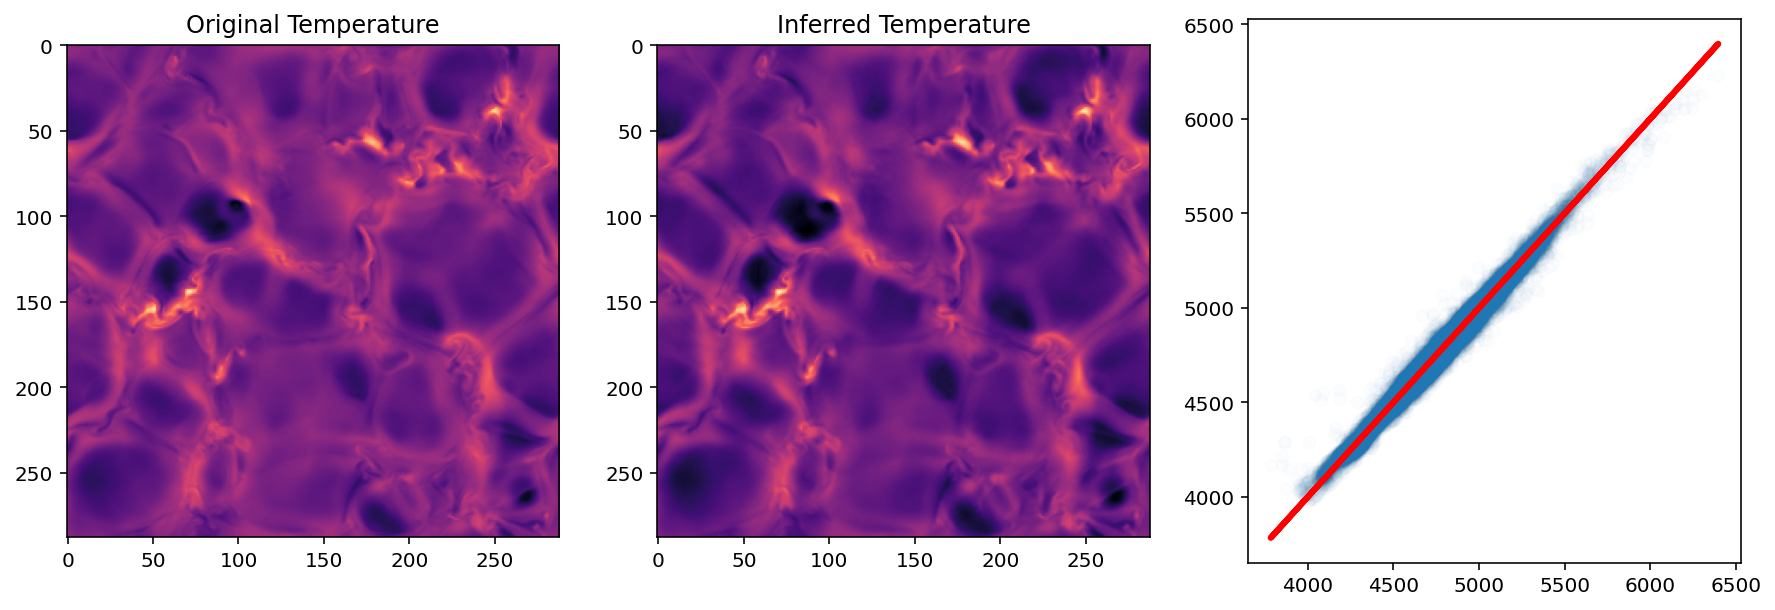

In [67]:
# Now we can, out of curiosity plot maps of parameters:
d = -30
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.imshow(denorm_og_1[:,d].reshape(288,288),cmap='magma')
plt.title("Original Temperature")
plt.subplot(132)
plt.imshow(denorm_preds_1[:,d].reshape(288,288),cmap='magma')
plt.title("Inferred Temperature")
plt.subplot(133)
plt.scatter(denorm_og_1[:,d],denorm_preds_1[:,d],alpha=0.01)
plt.plot(denorm_og_1[:,d],denorm_og_1[:,d],linewidth=3,color='red')

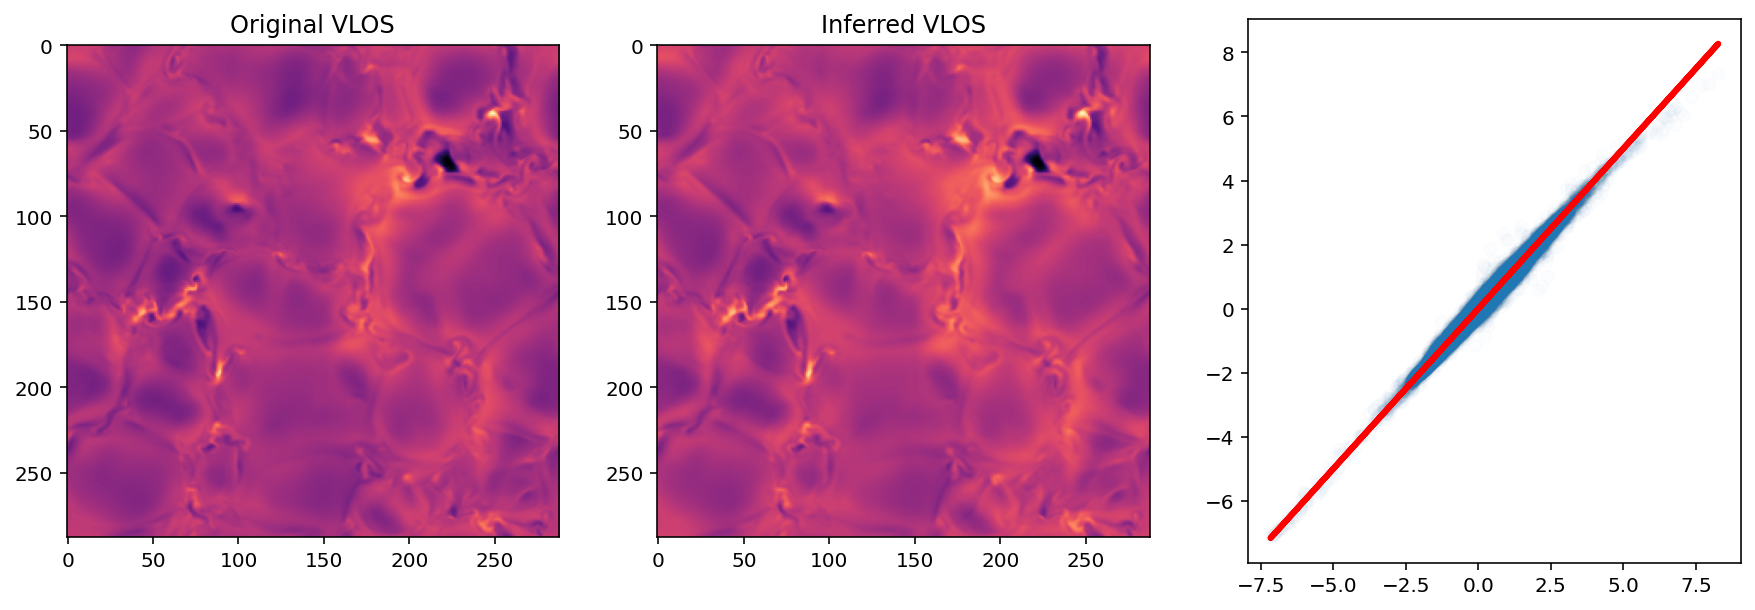

In [29]:
# Now we can, out of curiosity plot maps of parameters:
d = -30
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.imshow(denorm_og_2[:,d].reshape(288,288),cmap='magma')
plt.title("Original VLOS")
plt.subplot(132)
plt.imshow(denorm_preds_2[:,d].reshape(288,288),cmap='magma')
plt.title("Inferred VLOS")
plt.subplot(133)
plt.scatter(denorm_og_2[:,d],denorm_preds_2[:,d],alpha=0.01)
plt.plot(denorm_og_2[:,d],denorm_og_2[:,d],linewidth=3,color='red')

#### Packaging to FITS

In [68]:
atmos_new = np.copy(atmos)
atmos_new = atmos_new[:,:,:,u:l]
atmos_new[2] = np.copy(denorm_preds_1.reshape(288,288,50))
atmos_new[9] = np.copy(denorm_preds_2.reshape(288,288,50)*-1e5)
print(np.min(atmos_new[9]))

-966012.295179899


In [70]:
myhdu = FITS.PrimaryHDU(atmos_new)
myhdu.writeto("50G.ngrey.288x100x288_atmos_50_compressed-noconv-2.fits",overwrite='True')

### Analyzing Results

In [71]:
atmos_comp = FITS.open("50G.ngrey.288x100x288_atmos_50_compressed-noconv-2.fits")[0].data
atmos_comp[9]/=-1e5 #cm to km
formatted_atmos_comp = atmos_comp.reshape(12,288*288,50)
print(formatted_atmos_comp.shape)

atmos = FITS.open("50G.ngrey.288x100x288_atmos_61.fits")[0].data
atmos[9]/=-1e5 #cm to km
formatted_atmos = atmos[:,:,:,u:l].reshape(12,288*288,50) 
print(formatted_atmos.shape)

(12, 82944, 50)
(12, 82944, 50)


#### RMSE

In [73]:
def rmse_func(sp1,sp2):
    assert (len(sp1) == len(sp2)), "Arrays aren't same length?"
    num = (sp1-sp2)
    ans = np.sum(np.square(num))/len(sp1)
    return np.sqrt(ans)

In [74]:
rmse_arr_temp = []

for i in range(0,82944):
        rmse_arr_temp.append(rmse_func(formatted_atmos_comp[2,i],formatted_atmos[2,i]))
    
rmse_arr_temp = np.asarray(rmse_arr_temp)

mean: 28.73
med: 26.304


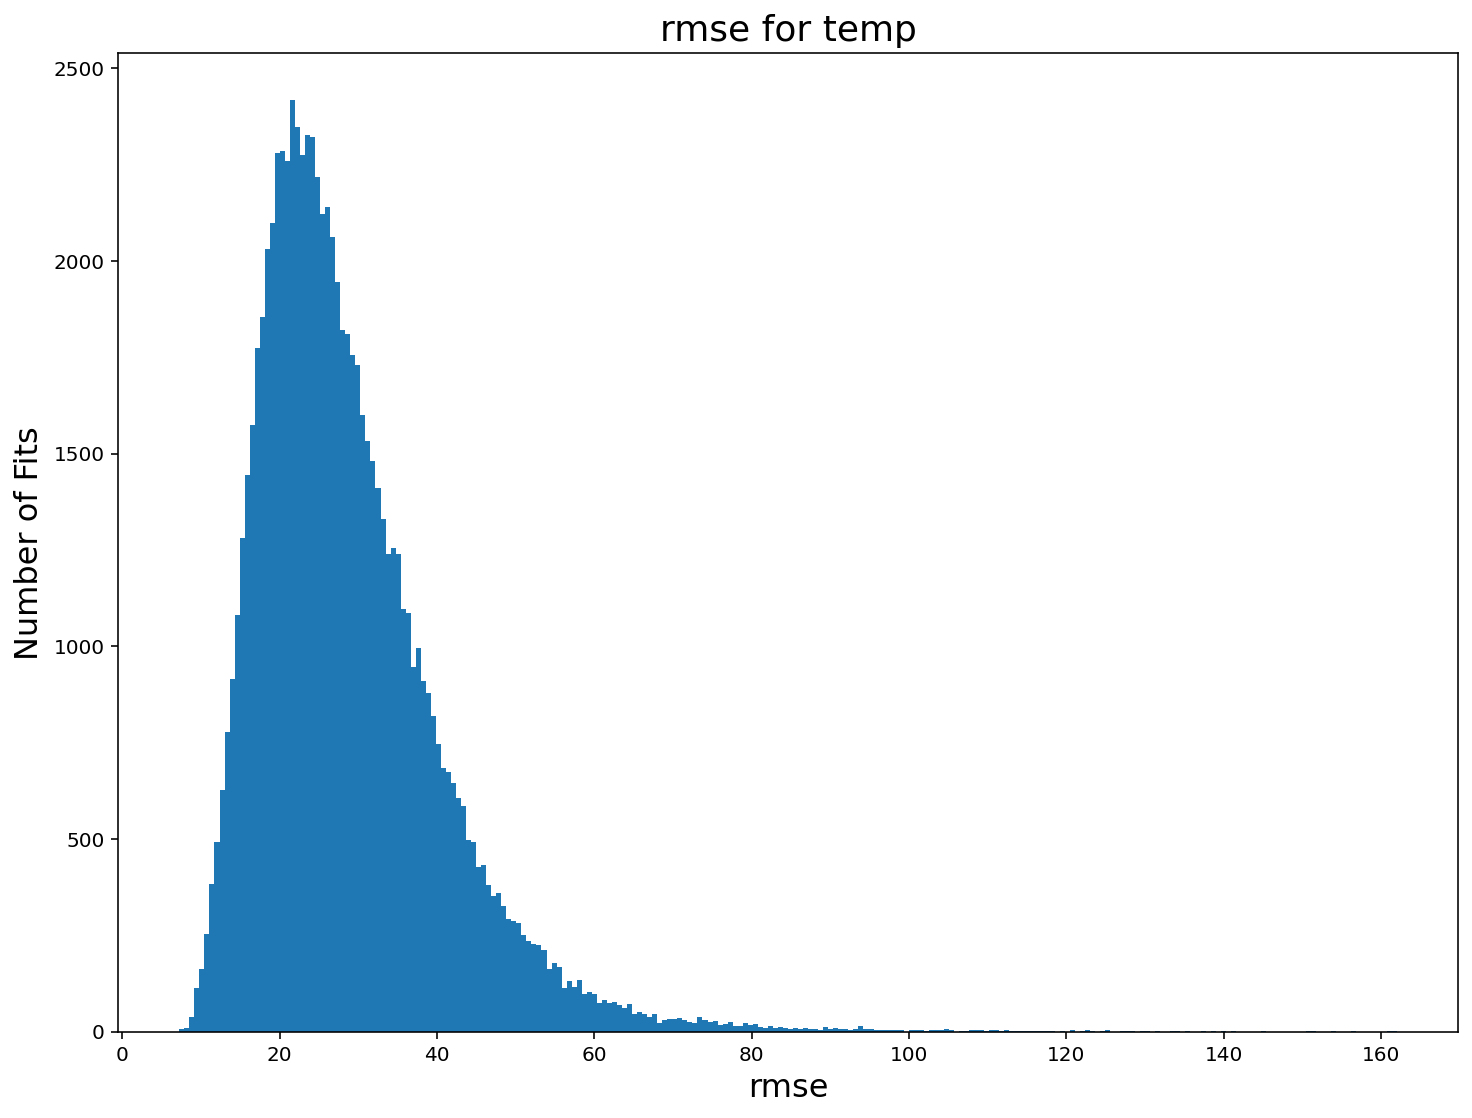

In [76]:
fig4 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig4.add_subplot(1,1,1)
ax1.hist(rmse_arr_temp, bins='auto')
ax1.set_title("", fontsize=18)
ax1.set_xlabel("rmse", fontsize=16)
ax1.set_title("rmse for temp", fontsize=18)
ax1.set_ylabel("Number of Fits", fontsize=16)

print("mean:", np.round(np.mean(rmse_arr_temp),3))
print("med:", np.round(np.median(rmse_arr_temp),3))

In [77]:
rmse_arr_vlos = []

for i in range(0,82944):
        rmse_arr_vlos.append(rmse_func(formatted_atmos_comp[9,i],formatted_atmos[9,i])) #what val for noise?
    
rmse_arr_vlos = np.asarray(rmse_arr_vlos)

mean: 0.08
med: 0.069


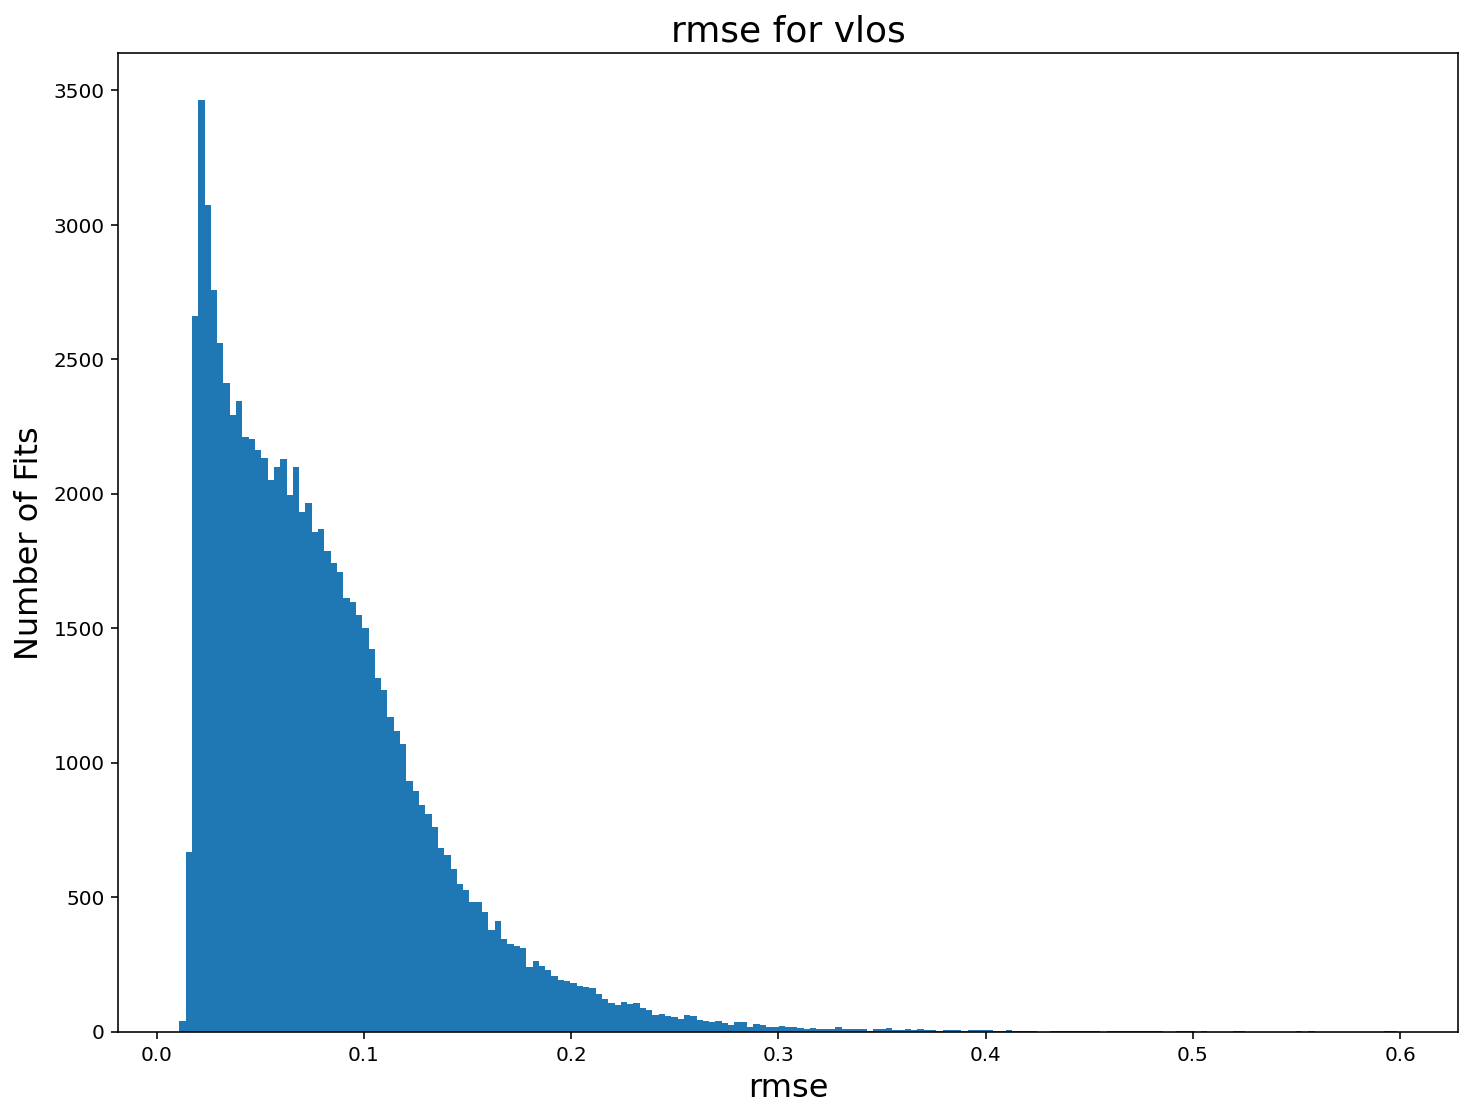

In [78]:
fig4 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig4.add_subplot(1,1,1)
ax1.hist(rmse_arr_vlos,bins='auto')
#ax1.hist(chisq_arr_temp)
ax1.set_title("rmse for vlos", fontsize=18)
ax1.set_xlabel("rmse", fontsize=16)
ax1.set_ylabel("Number of Fits", fontsize=16)

print("mean:", np.round(np.mean(rmse_arr_vlos),3))
print("med:", np.round(np.median(rmse_arr_vlos),3))

In [38]:
print(formatted_atmos_comp.shape)

(12, 82944, 50)


#### STDEV

In [79]:
stdev_arr_temp = []

for i in range(0,50):
    stdev_arr_temp.append(np.std(formatted_atmos_comp[2,:,i]-formatted_atmos[2,:,i]))
    
stdev_arr_temp = np.asarray(stdev_arr_temp)

Text(0, 0.5, 'stdev')

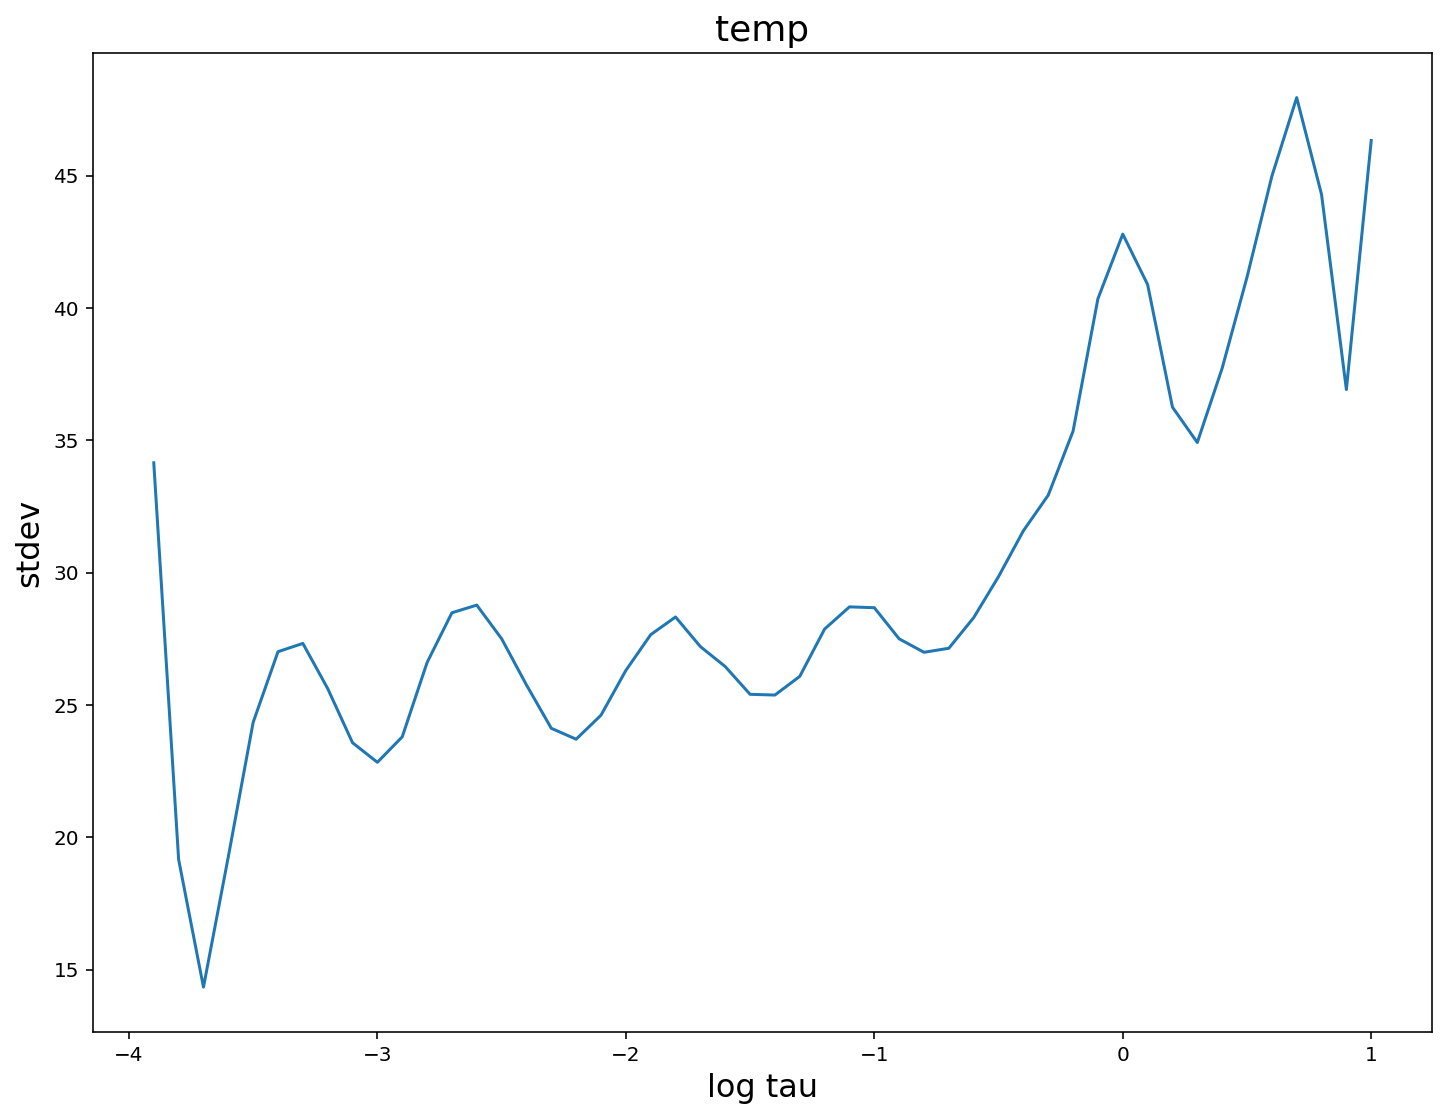

In [81]:
fig5 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig5.add_subplot(1,1,1)
ax1.plot(atmos[0,:,0][0][u:l], stdev_arr_temp)
#ax1.hist(chisq_arr_temp)
ax1.set_title("temp", fontsize=18)
ax1.set_xlabel("log tau", fontsize=16)
ax1.set_ylabel("stdev", fontsize=16)

#fig4.savefig("Nice/hist112-test-O2.png")

In [42]:
stdev_arr_vlos = []

for i in range(0,50):
    stdev_arr_vlos.append(np.mean(formatted_atmos_comp[9,:,i]-formatted_atmos[9,:,i]))
    
stdev_arr_vlos = np.asarray(stdev_arr_vlos)

Text(0, 0.5, 'stdev')

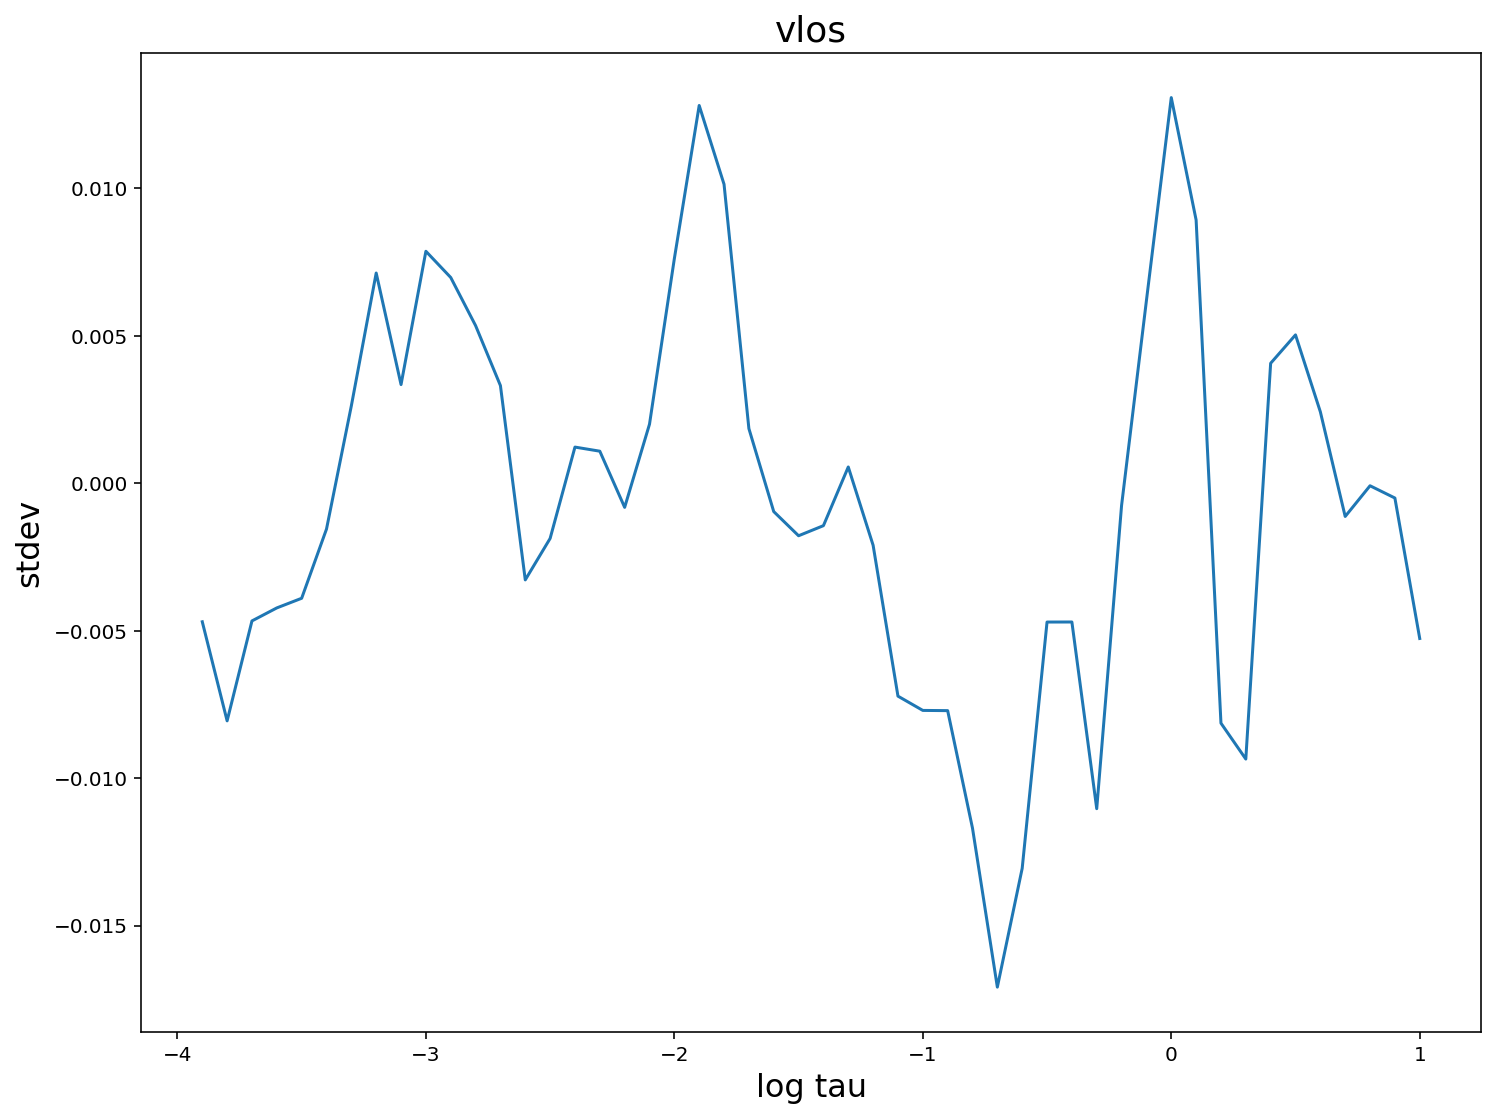

In [82]:
fig5 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig5.add_subplot(1,1,1)
ax1.plot(atmos[0,:,0][0][u:l], stdev_arr_vlos)
#ax1.hist(chisq_arr_temp)
ax1.set_title("vlos", fontsize=18)
ax1.set_xlabel("log tau", fontsize=16)
ax1.set_ylabel("stdev", fontsize=16)

#fig4.savefig("Nice/hist112-test-O2.png")